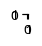

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.multimodal_datasets import MultimodalMarginalLatentDataset
from src.multimodal_models import BSSVAE, JMVAE
from src.multimodal_train_eval import predict_multimodal
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
from src.src.cluster_utils import load_model_full, get_latent


In [4]:
from src.cluster_utils import get_all_rpauc
from joblib import Parallel, delayed

def get_best_given_dir_diag2(maindir, set, idf='', filters=None):
    folders = [x for x in glob.glob(f'{maindir}/*/*{set}_results*.csv') if '_OLD_' not in x]
    files = {x.split('/')[-1].split('_24')[0]\
             .replace('RedoHP_','').replace('_train_','').replace('CNNVAE','Conv')\
             .replace('OldPruned','').replace('ExpDataTop78','').replace('latent','ld').replace('kld','kl')\
             .replace('ExpData17peps','').replace('OldDataNoPrune','').replace('_KFold_0','')\
             .replace('ExpAll_','').replace('OldAll_','').replace('OldDataTop15','').replace('OldDataTop20','').lstrip('_').rstrip('_'): x for x in folders}
    if filters is not None:
        files = {key: value for key, value in files.items() if any(keyword in key for keyword in filters)}

    baselines = pd.read_csv(folders[0]).query('input_type.str.contains("TBCR") or input_type.str.contains("tcrdist")')
    baselines['name'] = ''
    out = pd.concat([baselines] + [find_best_not_agg(pd.read_csv(path)).assign(name=name) for name, path in files.items()]).assign(identifier=idf)
    out['epoch'] = out['input_type']
    out['input_type'] = out.apply(lambda x: x['name']+'_'+x['input_type'] if x['name']!='' else x['input_type'], axis=1)#['name']+'_'+out['input_type']
    out['name'] = out.apply(lambda x: x['input_type'] if 'TBCR' in x['name'] or 'tcrdist' in x['name'] else x['name'], axis=1)
    return out[[x for x in out.columns if not 'Unnamed' in x]]
    
def get_agg_given_dir_diag2(maindir, set, idf='', filters=None):
    folders = [x for x in glob.glob(f'{maindir}/*/*{set}_results*.csv') if '_OLD_' not in x]
    files = {x.split('/')[-1].split('_24')[0]\
             .replace('RedoHP_','').replace('_train_','').replace('CNNVAE','Conv')\
             .replace('OldPruned','').replace('ExpDataTop78','').replace('latent','ld').replace('kld','kl')\
             .replace('ExpData17peps','').replace('OldDataNoPrune','').replace('_KFold_0','')\
             .replace('ExpAll_','').replace('OldAll_','').replace('OldDataTop15','').replace('OldDataTop20','').lstrip('_').rstrip('_'): x for x in folders}
    if filters is not None:
        files = {key: value for key, value in files.items() if any(keyword in key for keyword in filters)}

    baselines = pd.read_csv(folders[0]).query('input_type.str.contains("TBCR") or input_type.str.contains("tcrdist")')
    baselines['name'] = ''
    out = pd.concat([baselines] + [find_agg(path).assign(name=name) for name, path in files.items()]).assign(identifier=idf)
    out['input_type'] = out.apply(lambda x: x['name']+'_'+x['input_type'] if x['name']!='' else x['input_type'], axis=1)#['name']+'_'+out['input_type']
    out['name'] = out.apply(lambda x: x['input_type'] if 'TBCR' in x['name'] or 'tcrdist' in x['name'] else x['name'], axis=1)
    
    return out[[x for x in out.columns if not 'Unnamed' in x]]

def get_rpcurve_stats(maindir, set, which, idf='', filters=None):
    res = get_agg_given_dir_diag2(maindir, set, idf, None) if which=='agg' else get_best_given_dir_diag2(maindir, set, idf, None)
    # stupid for loop
    out = []
    for k in res.input_type.unique():
        tmp = res.query('input_type==@k')
        out.append(get_all_rpauc(tmp['retention'].values[1:-1], tmp['mean_purity'].values[1:-1], tmp['input_type'].unique()[0], tmp['name'].unique()[0]))
    return pd.DataFrame(out).sort_values('p70_r35_auc',ascending=False)
def rpauc_wrapper(df, input_type):
    tmp = df.query('input_type==@input_type')
    ret = tmp['retention'].values[1:-1]
    pur = tmp['mean_purity'].values[1:-1]
    return get_all_rpauc(ret, pur, input_type, None)
    
def find_best_not_agg(intervals, nm=None):
    tmp = intervals.query('not input_type.str.contains("TBCR") and not input_type.str.startswith("agg") and not input_type.str.contains("tcrdist")')
    results = pd.DataFrame(Parallel(n_jobs=5)(delayed(rpauc_wrapper)(df=tmp, input_type=k) for k in tmp.input_type.unique()))
    best=results.sort_values('p70_r35_auc', ascending=False).head(1).input_type.item()
    return tmp.query('input_type==@best')

def find_agg(fn):
    return pd.read_csv(fn).query('input_type.str.contains("agg")')


def get_agg_given_dir(maindir, set, idf):
    folders = [x for x in glob.glob(f'{maindir}/*/*{set}*.csv') if '_OLD_' not in x]
    baselines = pd.read_csv(folders[0]).query('input_type.str.contains("TBCR") or input_type.str.contains("tcrdist")')
    return pd.concat([baselines] + [find_agg(x) for x in folders]).assign(identifier=idf)
    
def get_best_given_dir(maindir, set, idf):
    folders = [x for x in glob.glob(f'{maindir}/*/*{set}*.csv') if '_OLD_' not in x]
    baselines = pd.read_csv(folders[0]).query('input_type.str.contains("TBCR") or input_type.str.contains("tcrdist")')
    return pd.concat([baselines] + [find_best_not_agg(pd.read_csv(x)) for x in folders]).assign(identifier=idf)

In [ ]:
# Joakim functions
from src.networkx_utils import collect_init_subgraphs, create_graph_from_subgraphsets, trim_graph_into_subgraphs
priority_abags = set()

#create initial graphs
#abag_adjmatrix np.array (nr_seq, nr_seqs)
init_graph = nx.Graph(agg_array)
datasize = len(init_graph)
size_cutoff = 3

okay_subgraphs, subgraphs_to_trim = collect_init_subgraphs(init_graph, size_cutoff = size_cutoff)
print(f"Number of decently sized subgraphs  {len(okay_subgraphs)}")
print(f"Number of subgraphs that need to be trimmed {len(subgraphs_to_trim)}")

if subgraphs_to_trim:
    trimmed_subgraphs = []
    for g in subgraphs_to_trim: trimmed_subgraphs.extend(trim_graph_into_subgraphs(g, size_cutoff=size_cutoff, priority_nodes=priority_abags,
                                                                                   remove_multnodes=remove_multnodes, priority_limit=priority_limit))
#trim the graphs
all_graphs = okay_subgraphs + trimmed_subgraphs
finalG = create_graph_from_subgraphsets(init_graph, all_graphs)
finalG_subgraphs = list(nx.connected_components(finalG))
final_sizes = [len(t) for t in finalG_subgraphs ]
print(f"Final graph sizes {final_sizes}")

In [2]:
new_df = pd.read_csv('../data/multimodal/240311_nettcr_pairedAB_expanded_noswap.csv')
old_df = pd.read_csv('../data/filtered/240416_nettcr_old_26pep_no_swaps.csv')
new_df_78 = pd.read_csv('../data/filtered/240507_nettcr_exp_pruned_noswap_78peps.csv')
new_df_17 = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')
old_df_15 = pd.read_csv('../data/filtered/240416_nettcr_old_top15peps_no_swaps.csv')
old_df_20 = pd.read_csv('../data/filtered/240507_nettcr_old_pruned_noswap_20peps.csv')

In [3]:
tbcr = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0)
tbcr_valid = tbcr.query('partition==0')
tbcr_valid = tbcr_valid[[str(x) for x in tbcr_valid.index]+['peptide','binder','partition','raw_index']]
tbcr_array = tbcr_valid.iloc[:len(tbcr_valid), :len(tbcr_valid)].values

# Checking distmatrix 

In [8]:
import networkx as nx
from src.cluster_utils import *

## old stuff

In [13]:
files_dict = pkl_load('../output/240411_ClusteringTests/files_dict.pkl')
comp_dict = pkl_load('../output/240411_ClusteringTests/comp_dict.pkl')

In [37]:
# Select the best model from FullExp 0200 KL 1e-1
folder = files_dict['FullExp_KL_1e-1']
join = '_'.join([comp_dict['FullExp_KL_1e-1'][-2], comp_dict['FullExp_KL_1e-1'][-1]])+'_'
js = glob.glob(f'{folder}*kwargs*.json')[0]
pt = glob.glob(f'{folder}*{join}*.pt')[0]
model = load_model_full(pt, js, map_location='cpu')
latent_df = get_latent_df(model, pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv').query('partition==0'))

Reloading best model:
epoch: 10000
total: 0.133039653301239
reconstruction: 0.0919111892580986
kld: 0.024339670315384865
triplet: 0.016788793727755547
seq_accuracy: 0.9892194867134094
pos_accuracy: 0.9978100657463074
{'max_len_a1': 7, 'max_len_a2': 8, 'max_len_a3': 22, 'max_len_b1': 6, 'max_len_b2': 7, 'max_len_b3': 23, 'max_len_pep': 0, 'encoding': 'BL50LO', 'pad_scale': -20, 'a1_col': 'A1', 'a2_col': 'A2', 'a3_col': 'A3', 'b1_col': 'B1', 'b2_col': 'B2', 'b3_col': 'B3', 'pep_col': 'peptide', 'add_positional_encoding': True}


In [39]:
tbcr_valid['original_peptide'] = tbcr_valid['peptide']
tbcr_valid, tbcr_array = resort_baseline(tbcr_valid, latent_df, 'raw_index')
dist_matrix, dist_array, features, labels, encoded_labels, label_encoder = get_distances_labels_from_latent(latent_df)
other_array = tbcr_valid.iloc[:len(tbcr_valid), :len(tbcr_valid)].values
agg_array = 1 - np.multiply(1-dist_array, 1-other_array)


1471


In [40]:
len(latent_df), agg_array.shape

(1471, (1471, 1471))

In [41]:
G = nx.Graph(agg_array)
G

In [42]:
G.get_edge_data(1,2), agg_array[1,2]

({'weight': 0.4357023471901318}, 0.4357023471901318)

In [43]:
T = nx.minimum_spanning_tree(G)

In [ ]:
from src.networkx_utils import collect_init_subgraphs, create_graph_from_subgraphsets, trim_graph_into_subgraphs
priority_abags = set()

#create initial graphs
#abag_adjmatrix np.array (nr_seq, nr_seqs)
init_graph = nx.Graph(agg_array)
datasize = len(init_graph)
size_cutoff = 3

okay_subgraphs, subgraphs_to_trim = collect_init_subgraphs(init_graph, size_cutoff = size_cutoff)
print(f"Number of decently sized subgraphs  {len(okay_subgraphs)}")
print(f"Number of subgraphs that need to be trimmed {len(subgraphs_to_trim)}")

if subgraphs_to_trim:
    trimmed_subgraphs = []
    for g in subgraphs_to_trim: trimmed_subgraphs.extend(trim_graph_into_subgraphs(g, size_cutoff=size_cutoff, priority_nodes=priority_abags,
                                                                                   remove_multnodes=remove_multnodes, priority_limit=priority_limit))
#trim the graphs
all_graphs = okay_subgraphs + trimmed_subgraphs
finalG = create_graph_from_subgraphsets(init_graph, all_graphs)
finalG_subgraphs = list(nx.connected_components(finalG))
final_sizes = [len(t) for t in finalG_subgraphs ]
print(f"Final graph sizes {final_sizes}")

## Check with a small subset

In [9]:
subset_df = pd.read_csv('../data/filtered/240326_nettcr_paired_NOswaps.csv').query('peptide in ["GILGFVFTL", "RAKFKQLL", "LLWNGPMAV", "YLQPRTFLL","ELAGIGILTV"] and partition==0')

In [10]:
# load a CNN expAll small model to run agg matrix on the side
# load CNNVAE_ExpAl|_Smallerepoch_2500
# model = load_model_full('../output/240516_CNNVAE_DiffDatasets/240516_1703_CNNVAE_ExpAll_KF0_GroupSamplerSmaller_KL1e-1_LWT10_30kepochs_KFold_0_iksqch/epoch_2500_interval_checkpoint__fold00_kcv_240326_nettcr_paired_NOswaps_f00_240516_1703_CNNVAE_ExpAll_KF0_GroupSamplerSmaller_KL1e-1_LWT10_30kepochs_KFold_0_iksqch.pt',
#                         '../output/240516_CNNVAE_DiffDatasets/240516_1703_CNNVAE_ExpAll_KF0_GroupSamplerSmaller_KL1e-1_LWT10_30kepochs_KFold_0_iksqch/checkpoint_best_fold00_kcv_240326_nettcr_paired_NOswaps_f00_240516_1703_CNNVAE_ExpAll_KF0_GroupSamplerSmaller_KL1e-1_LWT10_30kepochs_KFold_0_iksqch_JSON_kwargs.json')

model = load_model_full('../output/240527_DiagnosticRound2/RedoHP_CNNVAE_latent_100_kld_1e-3_train_ExpAll_KFold_0_240529_1313_NK0Uy/checkpoint_best_fold00_kcv_240326_nettcr_paired_NOswaps_f00_RedoHP_CNNVAE_latent_100_kld_1e-3_train_ExpAll_KFold_0_240529_1313_NK0Uy.pt',
                        '../output/240527_DiagnosticRound2/RedoHP_CNNVAE_latent_100_kld_1e-3_train_ExpAll_KFold_0_240529_1313_NK0Uy/checkpoint_best_fold00_kcv_240326_nettcr_paired_NOswaps_f00_RedoHP_CNNVAE_latent_100_kld_1e-3_train_ExpAll_KFold_0_240529_1313_NK0Uy_JSON_kwargs.json')

latent = get_latent_df(model, subset_df)
xx = get_distances_labels_from_latent(latent, index_col='raw_index')
dm, da, labels = xx[0], xx[1], xx[3]

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
No GPUs available. Using CPU.
Reloading best model:
Best epoch: 19887
total: 0.08891265526269541
reconstruction: 0.07188191963953366
kld: 0.0003216291428662358
triplet: 0.016709108045253444
seq_accuracy: 0.9925578236579895
pos_accuracy: 0.9987985491752625


In [11]:
tbcr_subset = pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_140peps_labeled.csv', index_col=0).query('peptide in ["GILGFVFTL", "RAKFKQLL", "LLWNGPMAV", "YLQPRTFLL","ELAGIGILTV"] and partition==0')
tbcr_subset.groupby('peptide').count()

0    1    2    3    4    5    6    7    8    9  ...  9763  9764  \
peptide                                                       ...               
ELAGIGILTV   92   92   92   92   92   92   92   92   92   92  ...    92    92   
GILGFVFTL   233  233  233  233  233  233  233  233  233  233  ...   233   233   
LLWNGPMAV    75   75   75   75   75   75   75   75   75   75  ...    75    75   
RAKFKQLL    166  166  166  166  166  166  166  166  166  166  ...   166   166   
YLQPRTFLL    80   80   80   80   80   80   80   80   80   80  ...    80    80   

            9765  9766  9767  9768  original_peptide  binder  partition  \
peptide                                                                   
ELAGIGILTV    92    92    92    92                92      92         92   
GILGFVFTL    233   233   233   233               233     233        233   
LLWNGPMAV     75    75    75    75                75      75         75   
RAKFKQLL     166   166   166   166               166     166        166   
YLQPRTFLL     80    80    80    80                80      80         80   

            raw_index  
peptide                
ELAGIGILTV         92  
GILGFVFTL         233  
LLWNGPMAV          75  
RAKFKQLL          166  
YLQPRTFLL          80  

[5 rows x 9773 columns]

In [12]:
tbcr_subset, tbcr_subda = resort_baseline(tbcr_subset, dm, 'raw_index')

In [13]:
# Reset index and columns for DM so they match the tbcr subset 
dm.reset_index(drop=True, inplace=True)
dm.index = tbcr_subset.index.copy()
dm.columns = [list(tbcr_subset.index.copy()) + ['peptide', 'binder', 'origin', 'original_peptide', 'raw_index']]

# THEN CAN do the same subsampling //

In [14]:
# subsample to 4 and subsample a few
subsample = []
for p in tbcr_subset.peptide.unique():
    if p=="GILGFVFTL" or p=="RAKFKQLL":
        frac=0.5
    else:
        frac=0.9
    subsample.append(tbcr_subset.query('peptide==@p').sample(frac=frac, random_state=13))
tbcr_test = pd.concat(subsample)
tbcr_test = tbcr_test[[str(x) for x in tbcr_test.index]+['binder','partition','raw_index','peptide','original_peptide']]
dm_test = dm.loc[tbcr_test.index][list(tbcr_test.index.copy())+['peptide','binder','origin','original_peptide','raw_index']]
# Reset index to ordinal to match NetworkX tree just for this example
tbcr_test.reset_index(drop=True, inplace=True)
dm_test.reset_index(drop=True, inplace=True)
tbcr_test.columns = tbcr_test.index.tolist() + ['binder', 'partition', 'raw_index', 'peptide','original_peptide']
dm_test.columns = dm_test.index.tolist() + ['binder', 'partition', 'raw_index', 'peptide','original_peptide']
tbcr_test.groupby('peptide').count()

dm_test = dm_test.sort_values('peptide')
dm_test = dm_test[dm_test.index.tolist() + ['binder','partition','raw_index','peptide']]
tbcr_test = tbcr_test.sort_values('peptide')
tbcr_test = tbcr_test[tbcr_test.index.tolist() + ['binder','partition','raw_index','peptide']]

In [15]:
tbcr_test.groupby('peptide').agg(count=(0, 'count'))

count
peptide          
ELAGIGILTV     83
GILGFVFTL     116
LLWNGPMAV      68
RAKFKQLL       83
YLQPRTFLL      72

In [16]:
# Take min-max for better visualization
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
mms = MinMaxScaler()
le = LabelEncoder()
labels = dm_test['peptide'].values
encoded_labels = le.fit_transform(labels)

da_test = dm_test[dm_test.index].values
da_tbcr = tbcr_test[tbcr_test.index].values
da_agg1 = 1-np.multiply( mms.fit_transform((1-da_test)), mms.fit_transform((1-da_tbcr)))
da_agg2 = 1-np.multiply( (1-da_test), (1-da_tbcr))


### distance matrix stats and heatmaps 

In [17]:
import numpy as np

# Evaluate dist matrix
def evaluate_distance_matrix(distance_matrix, labels):
    unique_classes = np.unique(labels)
    intra_class_distances = []
    inter_class_distances = []

    # Compute intra-class distances
    for class_label in unique_classes:
        intra_indices = np.where(labels == class_label)[0]
        intra_class_distances.append(distance_matrix[np.ix_(intra_indices, intra_indices)].mean())

    # Compute inter-class distances
    for i, class1 in enumerate(unique_classes):
        for j, class2 in enumerate(unique_classes):
            if class1 != class2:
                indices1 = np.where(labels == class1)[0]
                indices2 = np.where(labels == class2)[0]
                inter_class_distances.append(distance_matrix[np.ix_(indices1, indices2)].mean())

    mean_intra = np.mean(intra_class_distances)
    mean_inter = np.mean(inter_class_distances)
    ratio = mean_intra / mean_inter

    return mean_intra, mean_inter, ratio

# Assuming distance_matrix1, distance_matrix2, distance_matrix3, and labels are defined
results1 = evaluate_distance_matrix(mms.fit_transform(da_test), encoded_labels)
results2 = evaluate_distance_matrix(mms.fit_transform(da_tbcr), encoded_labels)
results3 = evaluate_distance_matrix(da_agg1, encoded_labels)
results4 = evaluate_distance_matrix(mms.fit_transform(da_agg2), encoded_labels)

print("Results for CNNVAE:\tIntra-class: {:.4f}, Inter-class: {:.4f}, Ratio: {:.4f}".format(*results1))
print("Results for TBCRalign:\tIntra-class: {:.4f}, Inter-class: {:.4f}, Ratio: {:.4f}".format(*results2))
print("Results for aggregate1:\tIntra-class: {:.4f}, Inter-class: {:.4f}, Ratio: {:.4f}".format(*results3))
print("Results for aggregate2:\tIntra-class: {:.4f}, Inter-class: {:.4f}, Ratio: {:.4f}".format(*results4))


Results for CNNVAE:	Intra-class: 0.6583, Inter-class: 0.7352, Ratio: 0.8954
Results for TBCRalign:	Intra-class: 0.6832, Inter-class: 0.7416, Ratio: 0.9213
Results for aggregate1:	Intra-class: 0.8729, Inter-class: 0.9271, Ratio: 0.9415
Results for aggregate2:	Intra-class: 0.7338, Inter-class: 0.8042, Ratio: 0.9124


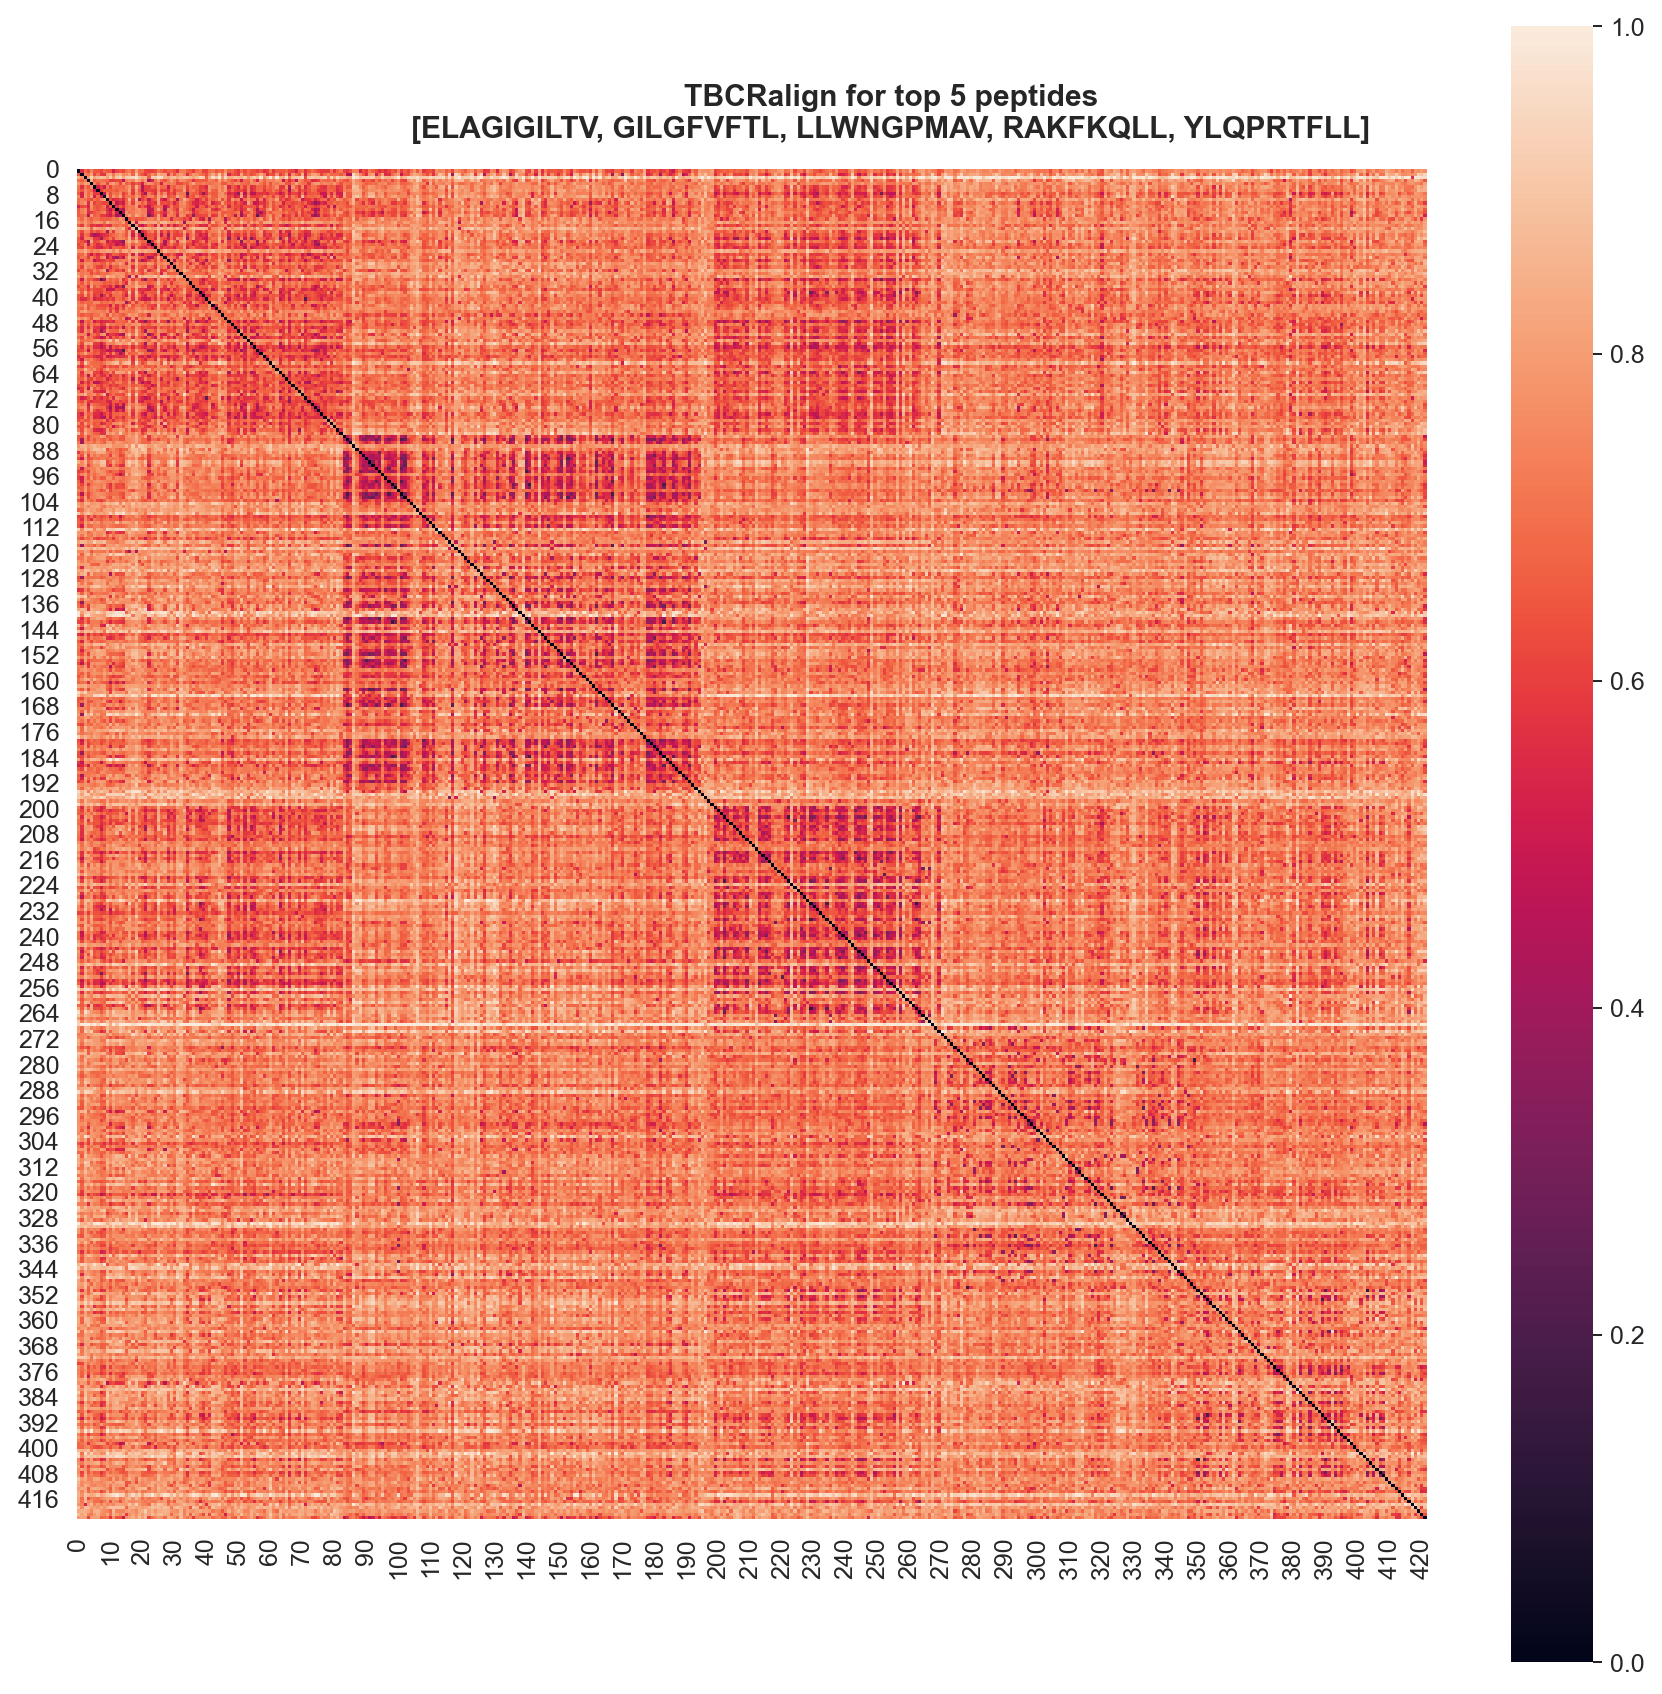

In [18]:
f,a = plt.subplots(1,1,figsize=(10,10))
sns.heatmap( mms.fit_transform(da_tbcr), square=True, ax = a)
f.suptitle('TBCRalign for top 5 peptides\n[ELAGIGILTV, GILGFVFTL, LLWNGPMAV, RAKFKQLL, YLQPRTFLL]',fontweight='semibold',  y=0.9)
f.tight_layout()

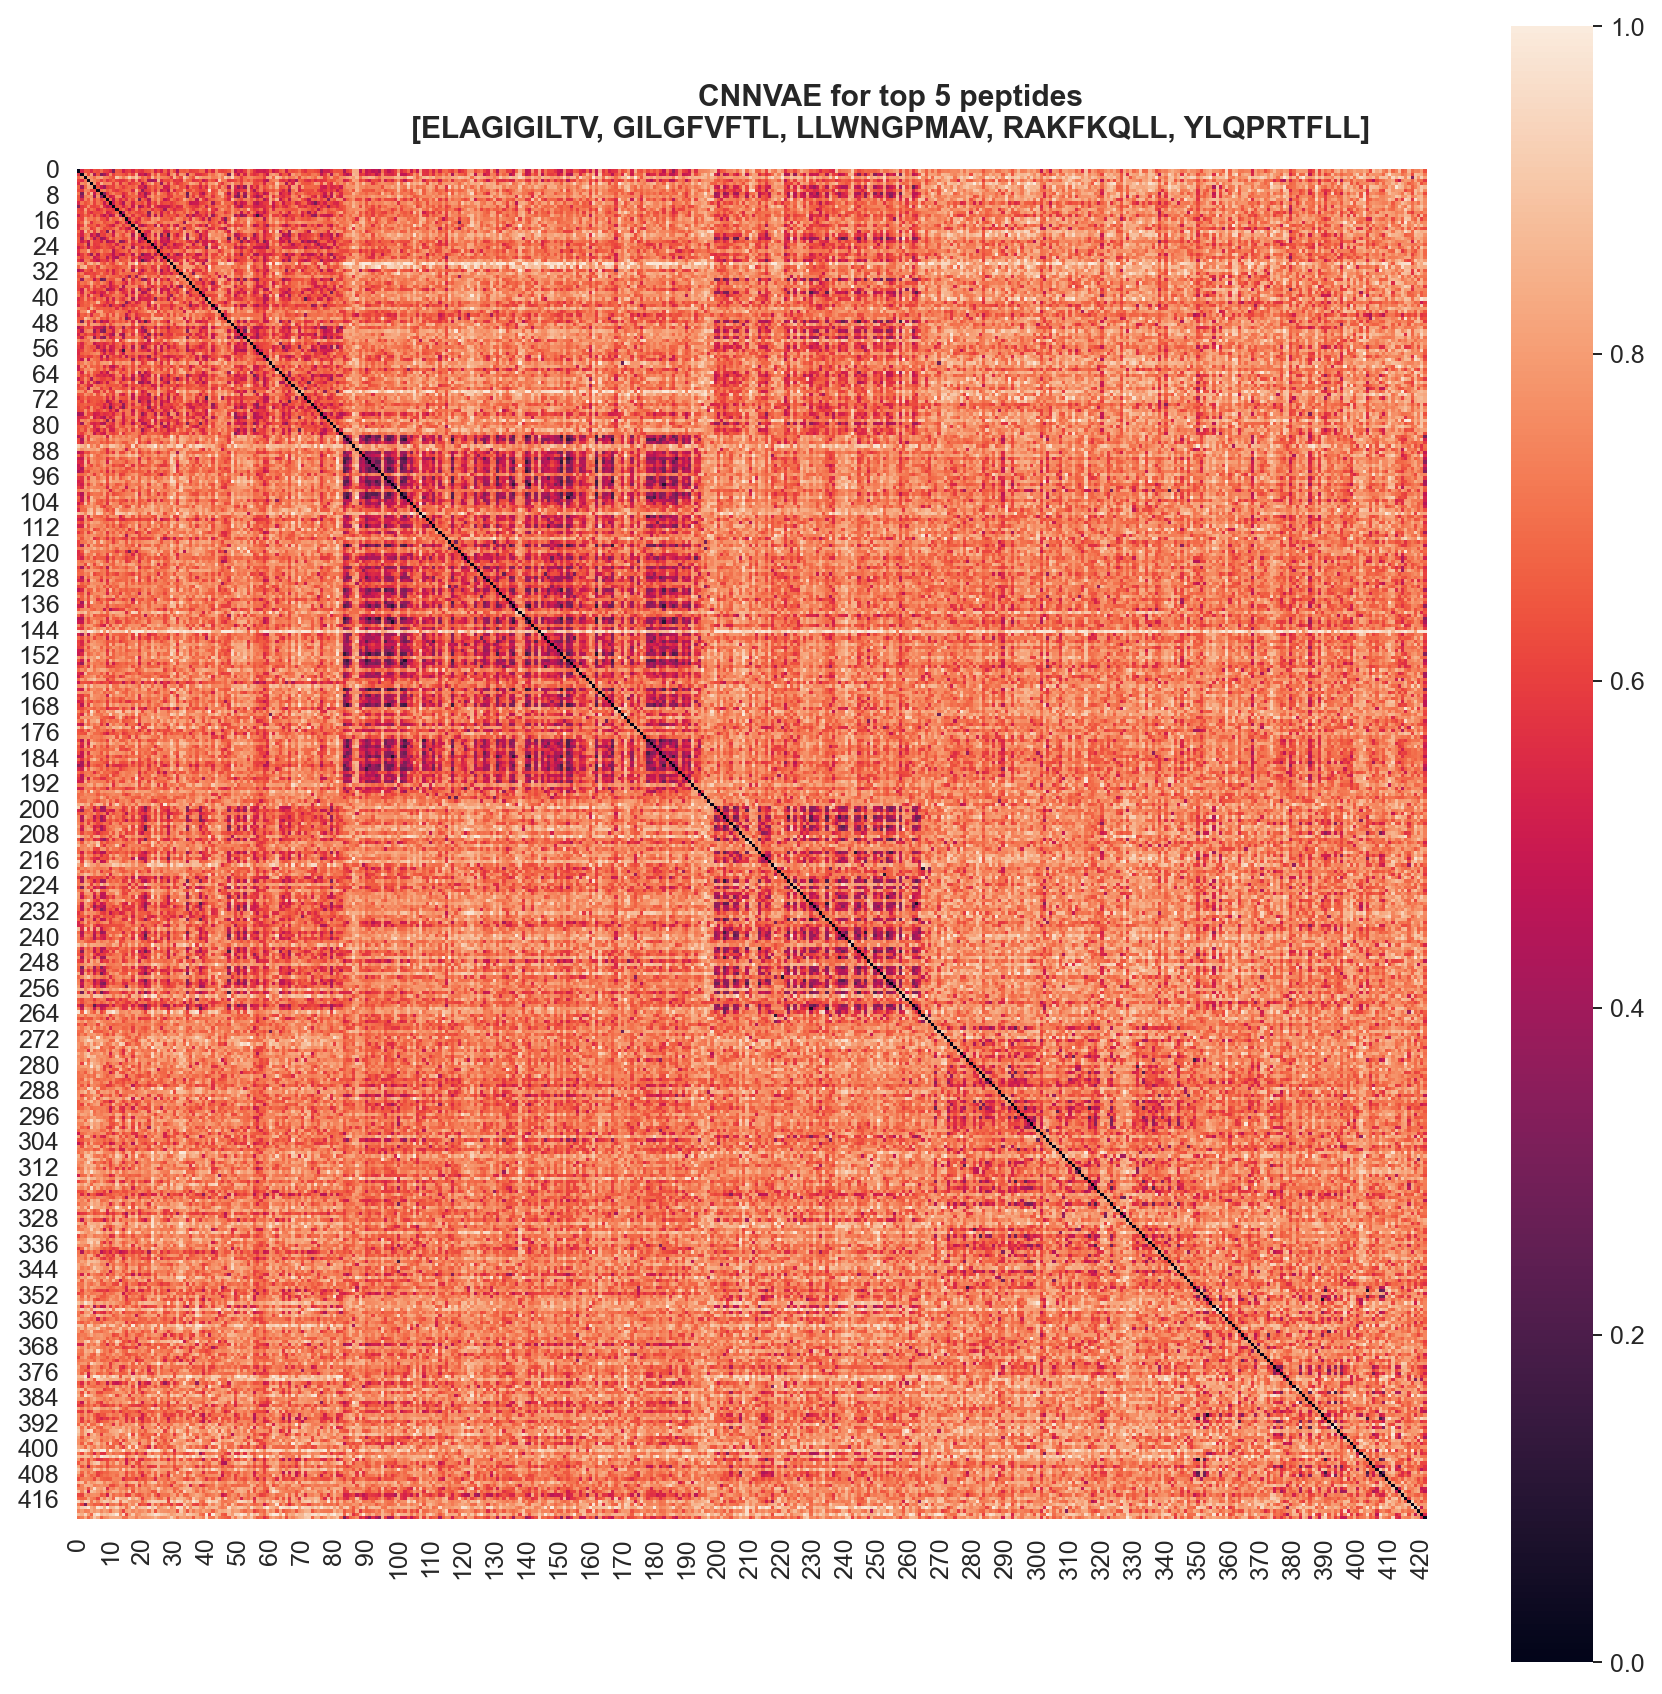

In [19]:
f,a = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(mms.fit_transform(da_test), square=True, ax = a)
f.suptitle('CNNVAE for top 5 peptides\n[ELAGIGILTV, GILGFVFTL, LLWNGPMAV, RAKFKQLL, YLQPRTFLL]', fontweight='semibold', y=0.9)
f.tight_layout()

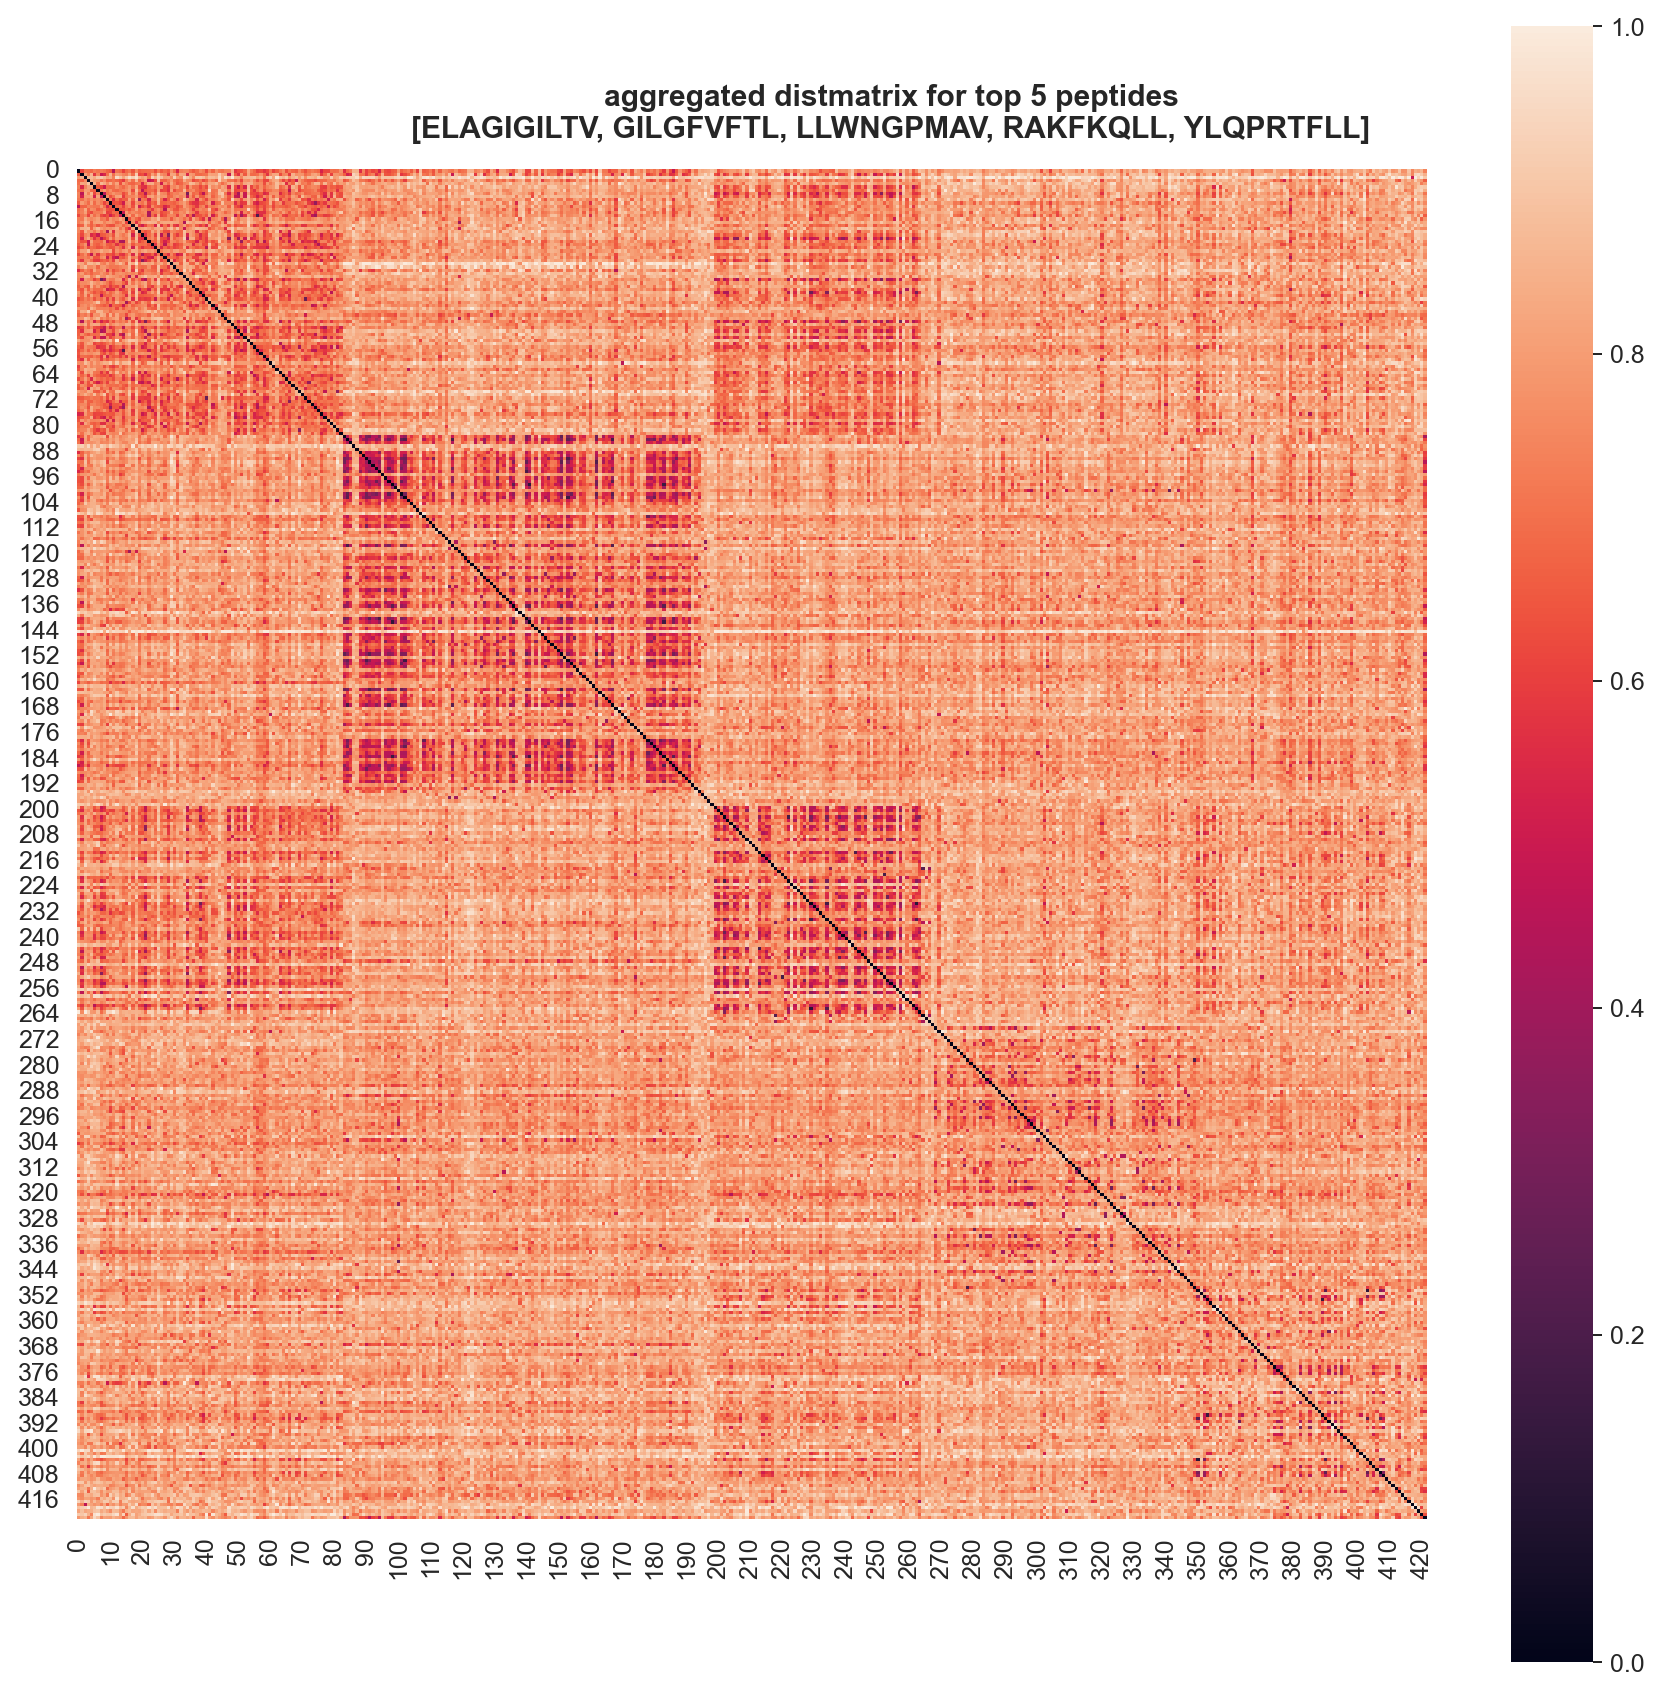

In [20]:
f,a = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(mms.fit_transform(da_agg2), square=True, ax = a)
f.suptitle('aggregated distmatrix for top 5 peptides\n[ELAGIGILTV, GILGFVFTL, LLWNGPMAV, RAKFKQLL, YLQPRTFLL]', fontweight='semibold',y=0.9)
f.tight_layout()

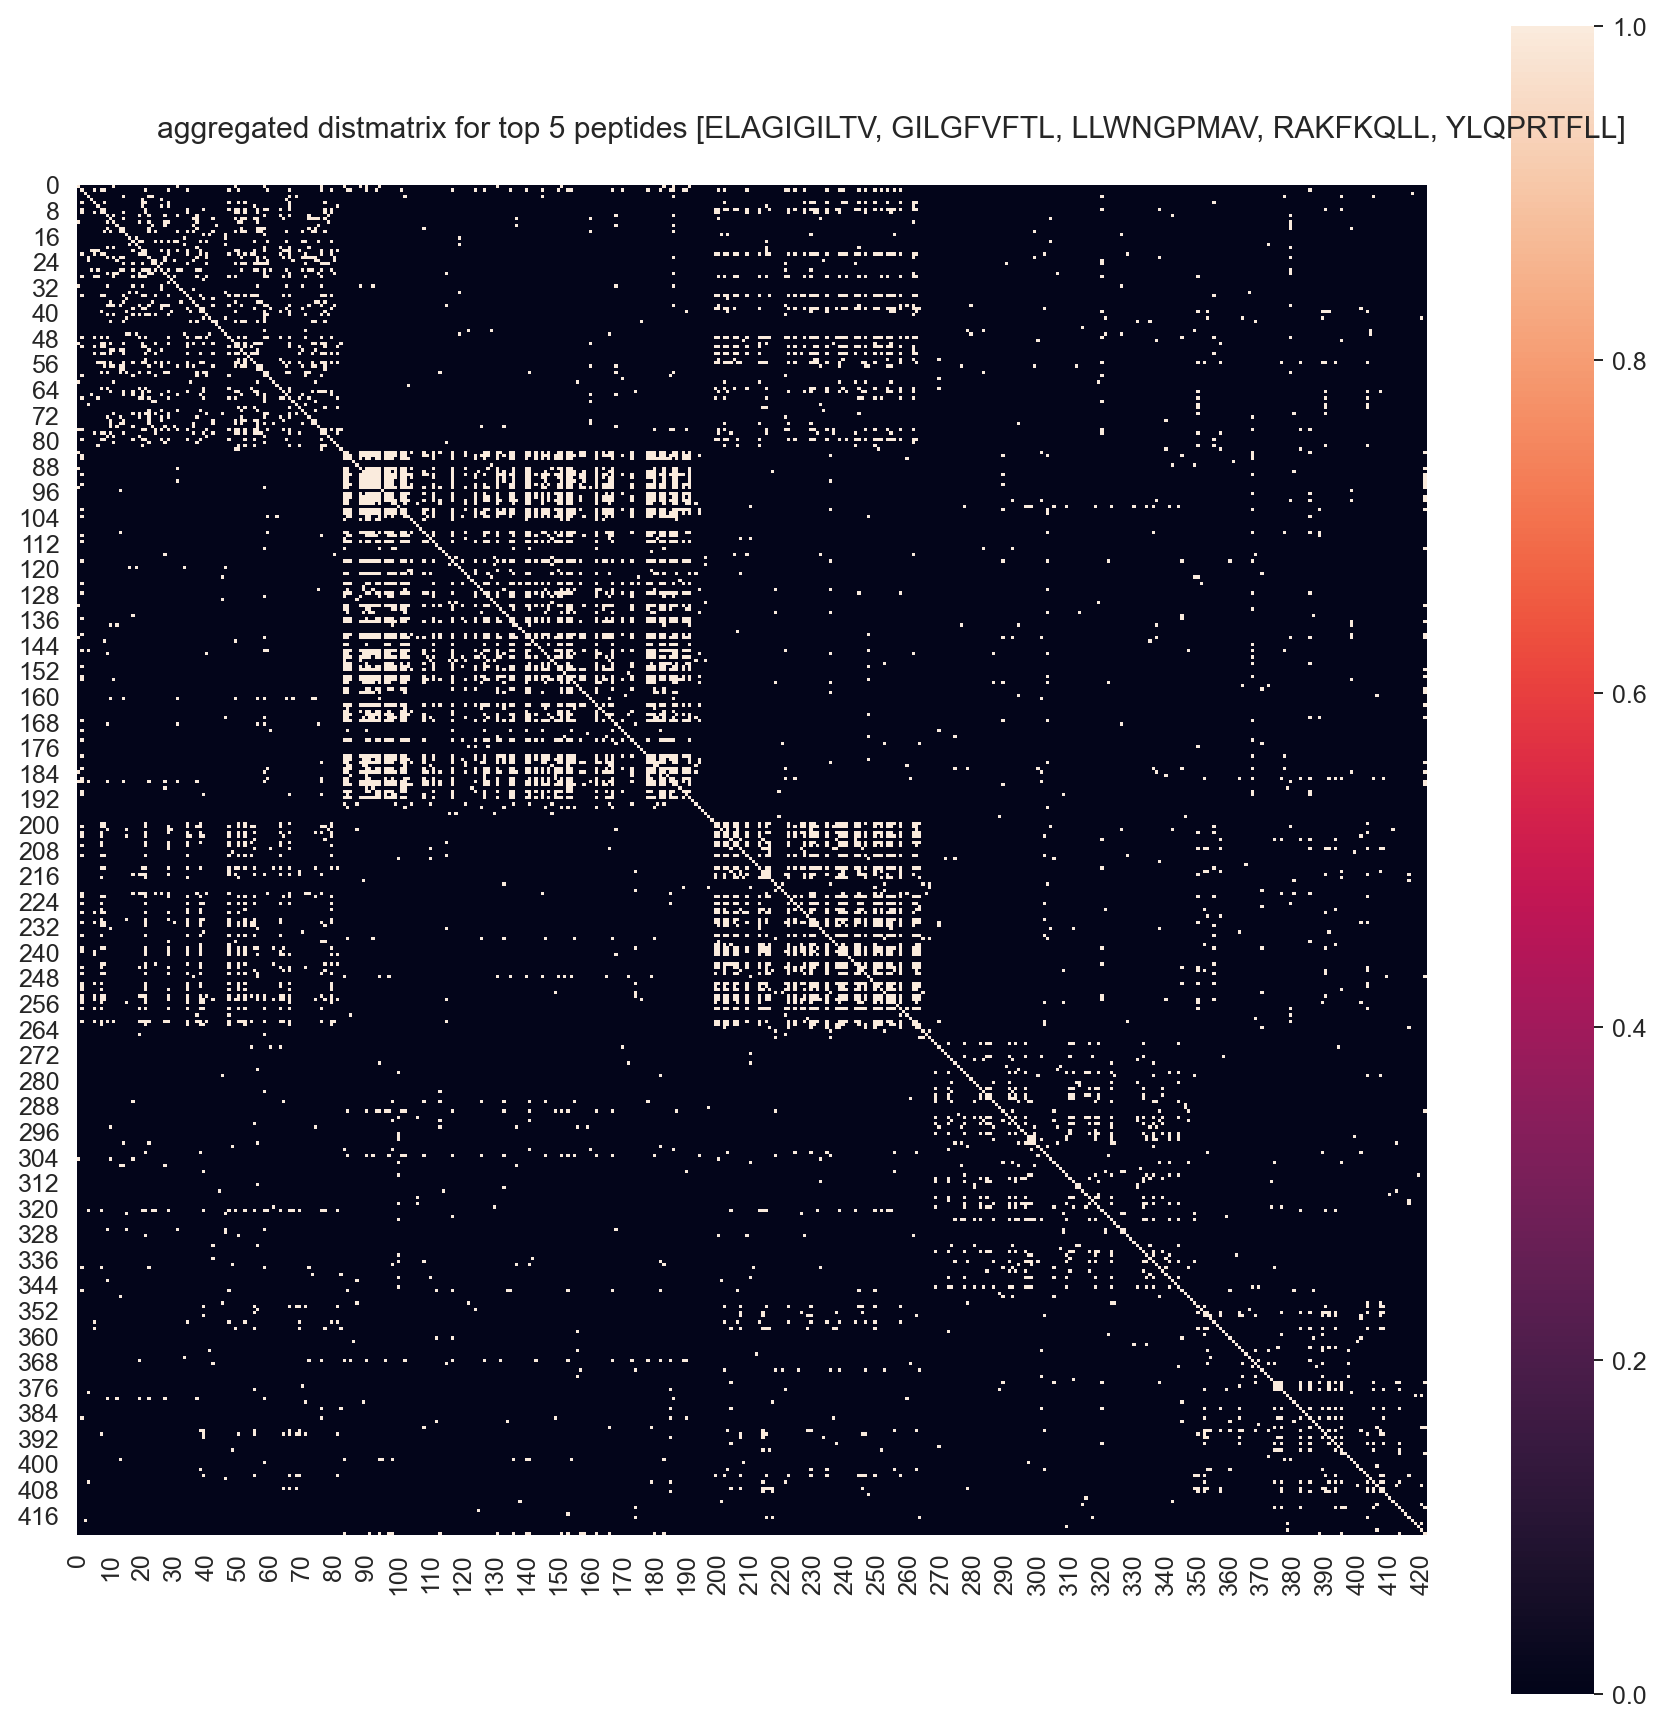

In [23]:
f,a = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(mms.fit_transform(da_agg2)<0.6, square=True, ax = a)
f.suptitle('aggregated distmatrix for top 5 peptides [ELAGIGILTV, GILGFVFTL, LLWNGPMAV, RAKFKQLL, YLQPRTFLL]', y=0.9)
f.tight_layout()

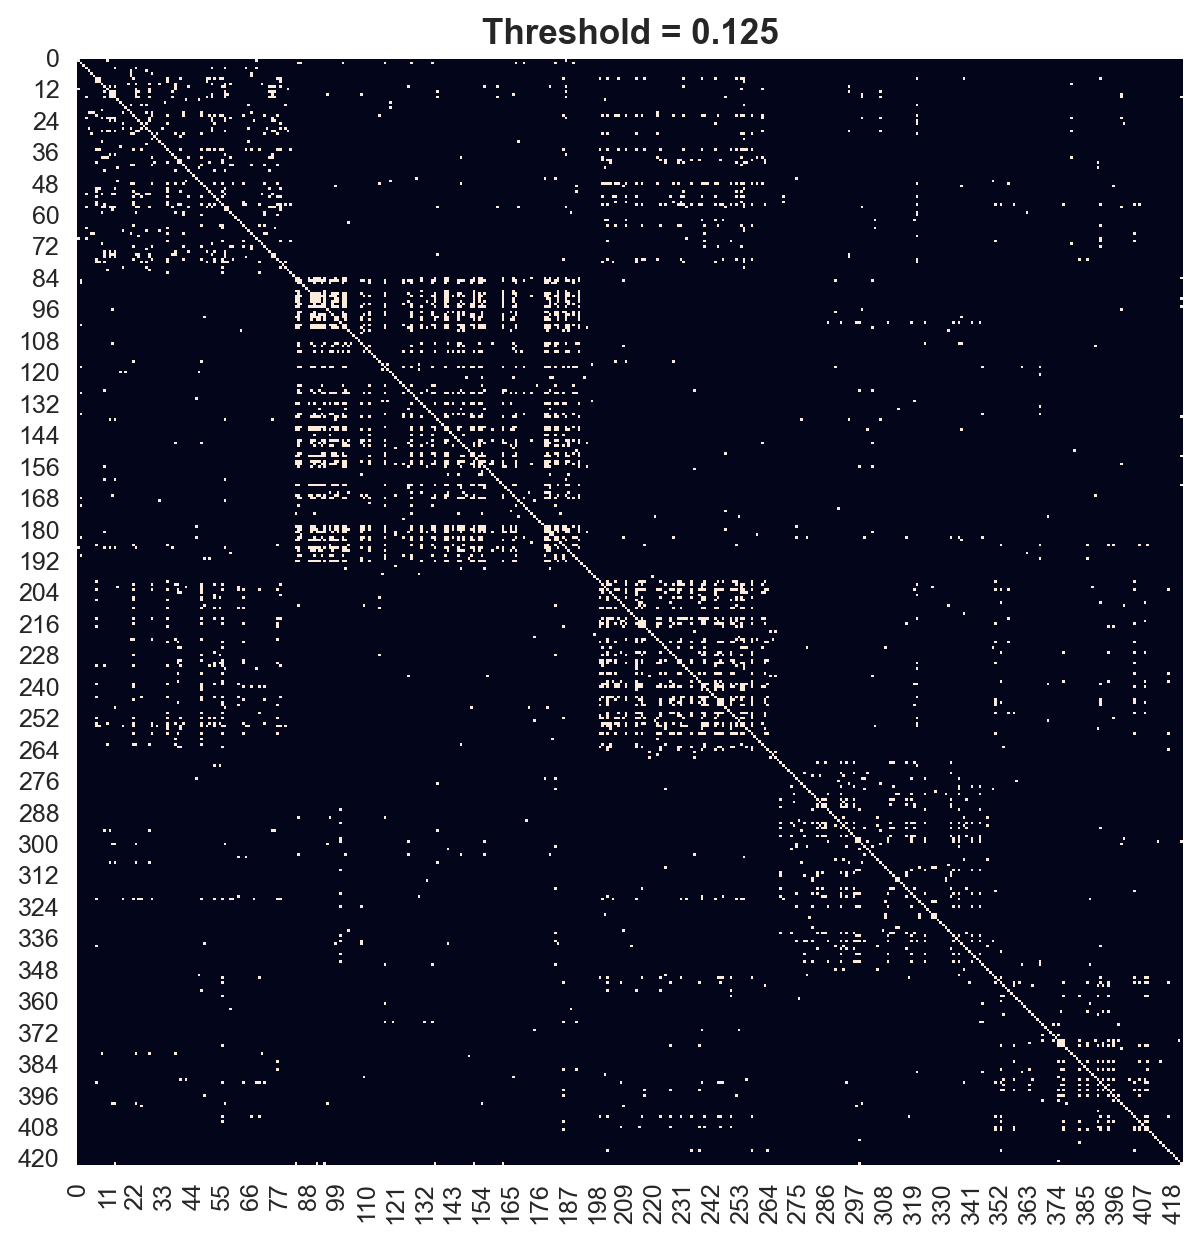

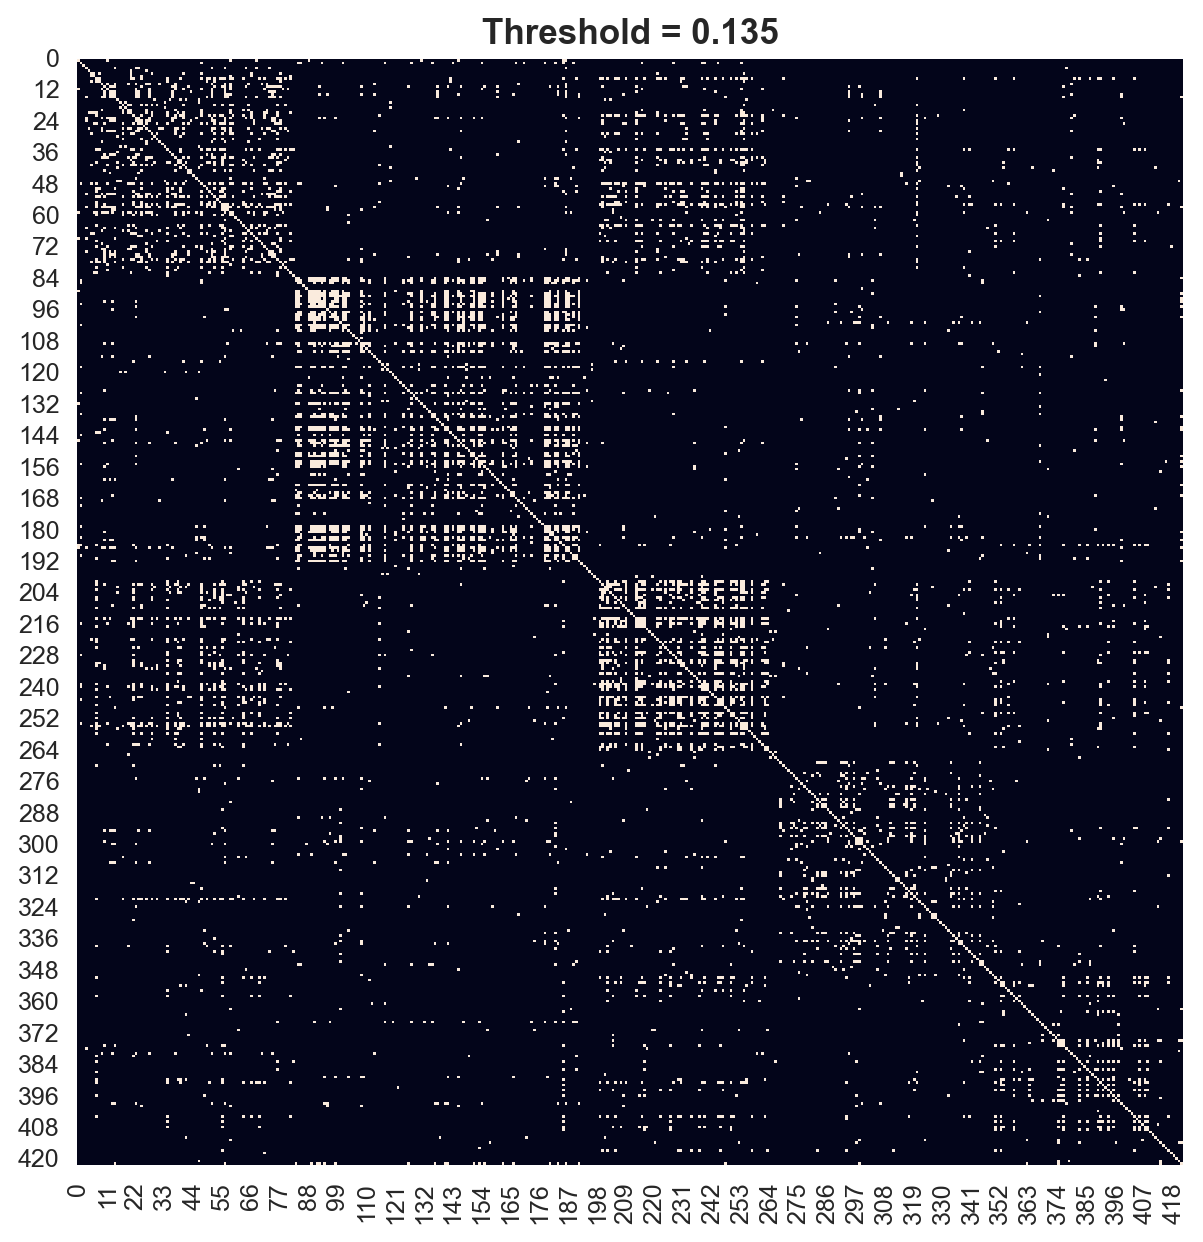

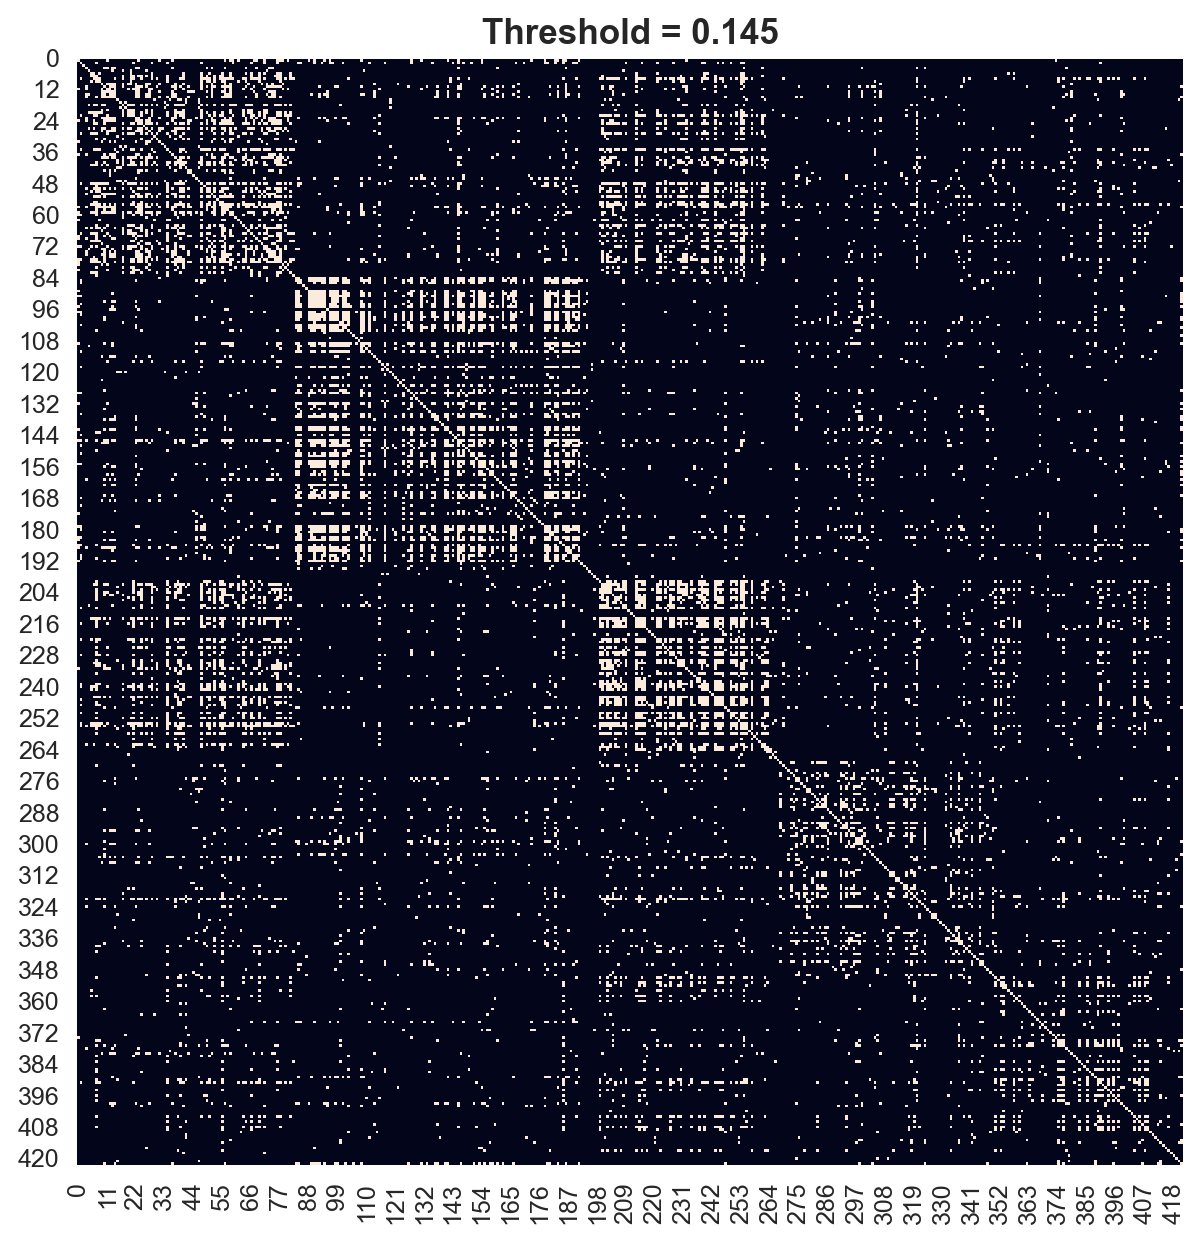

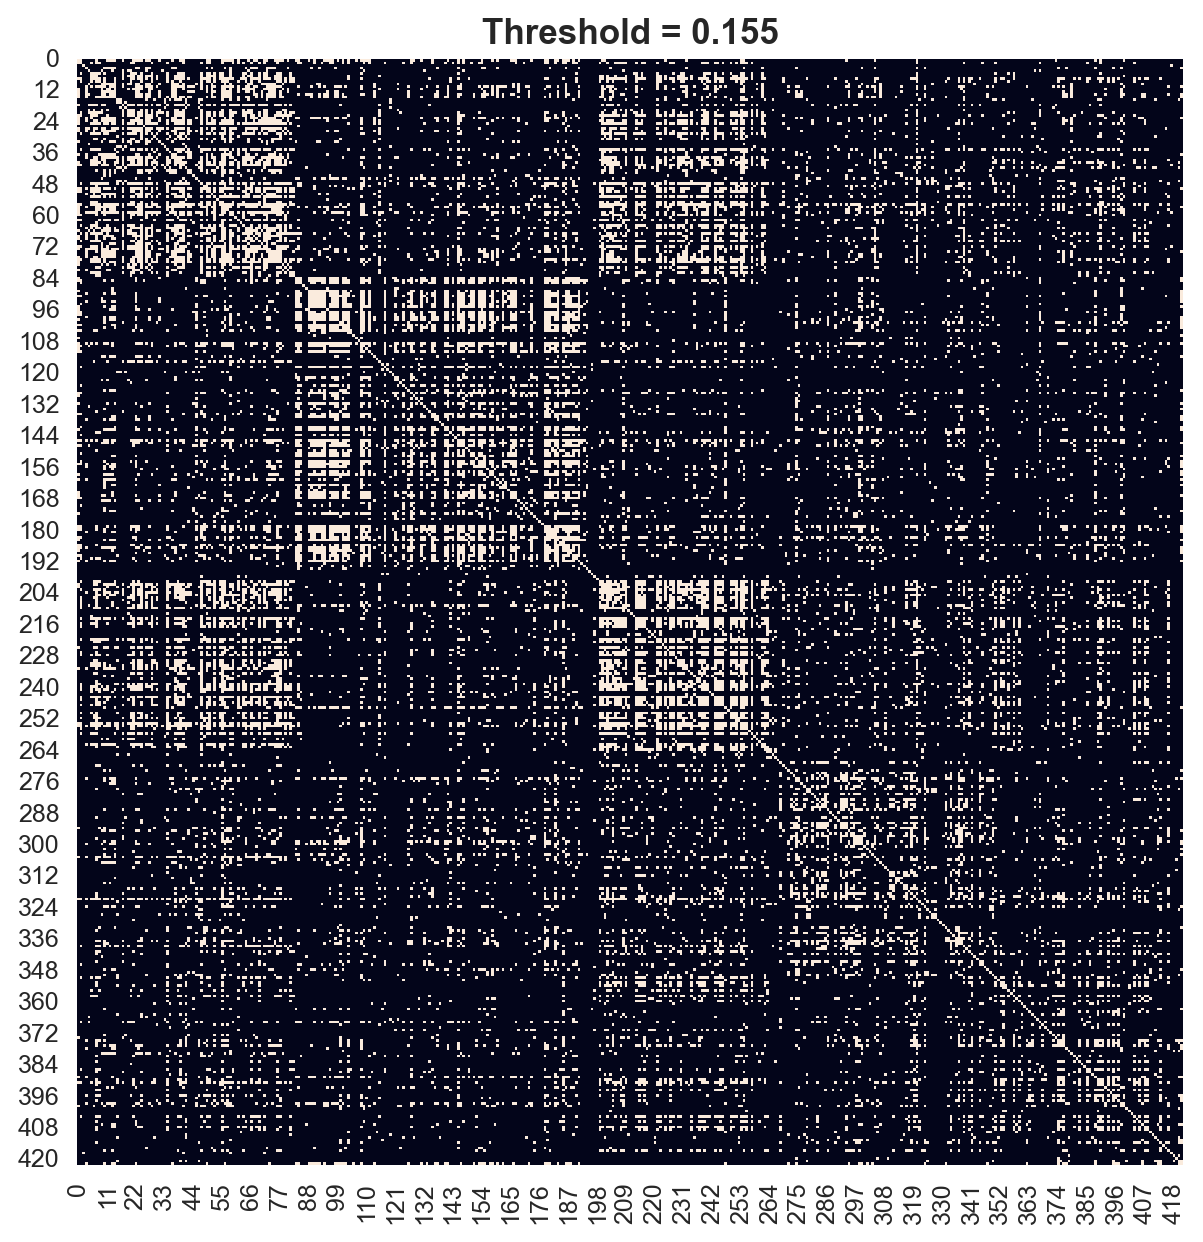

In [24]:
# for t in [0.

for t in [0.125, 0.135, 0.145, 0.155]:
    f,a = plt.subplots(1,1,figsize=(7,7))
    sns.heatmap(da_tbcr<t, square=True, ax = a, cbar=False)
    a.set_title(f'Threshold = {t}', fontweight='semibold', fontsize=14)
    # f.suptitle('CNNVAE for top 5 peptides\n[ELAGIGILTV, GILGFVFTL, LLWNGPMAV, RAKFKQLL, YLQPRTFLL]', fontweight='semibold', y=0.9)
    f.tight_layout()

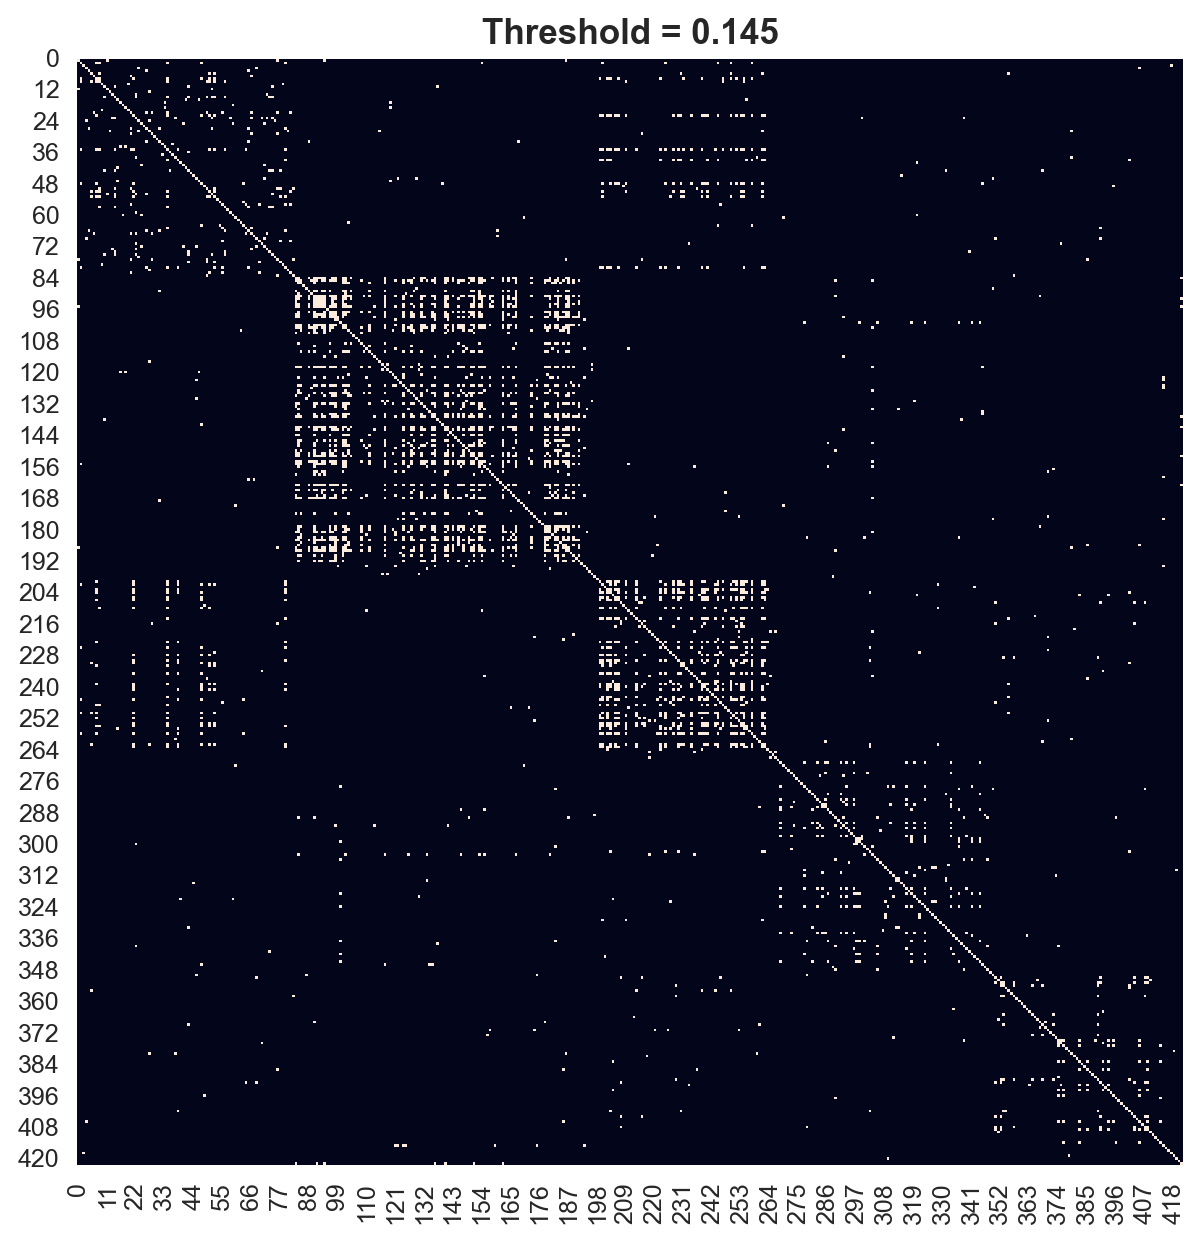

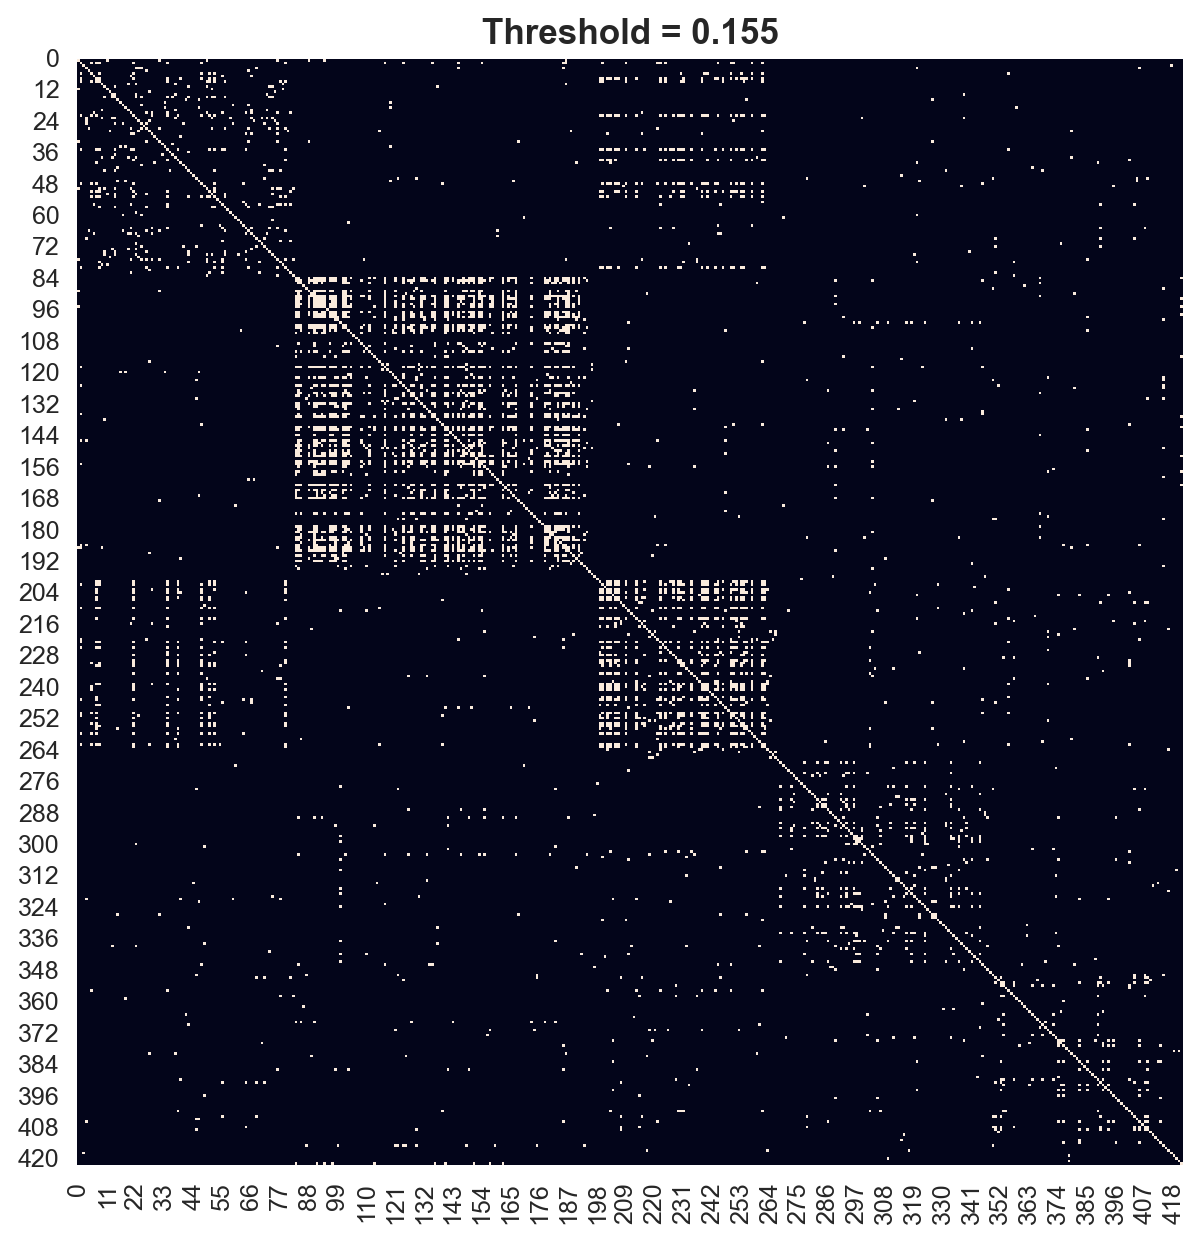

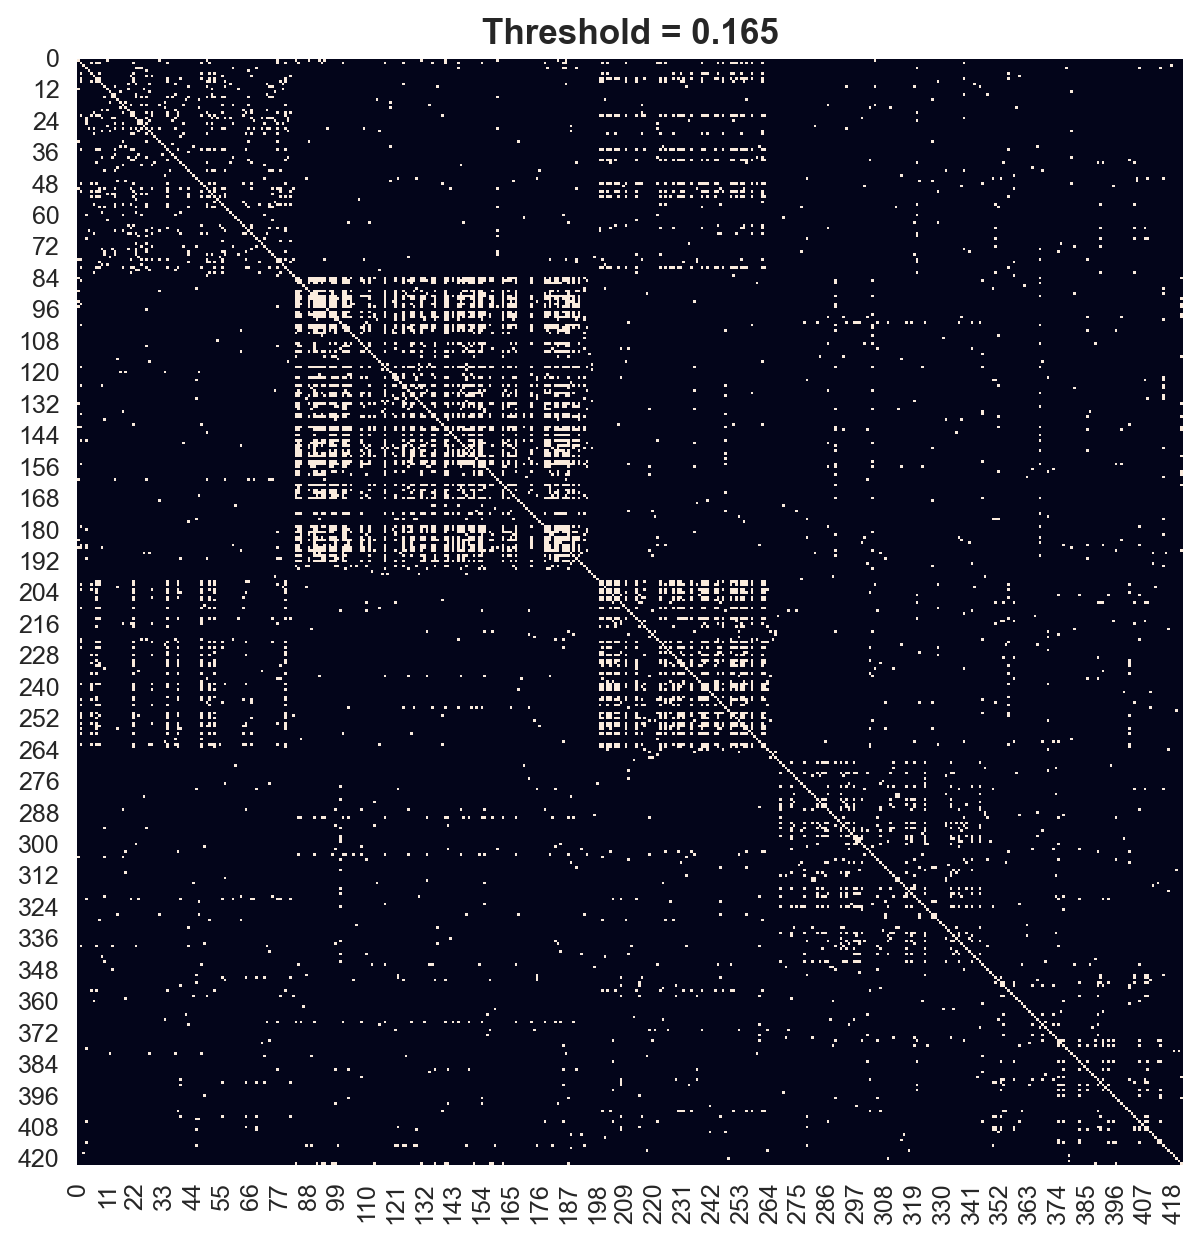

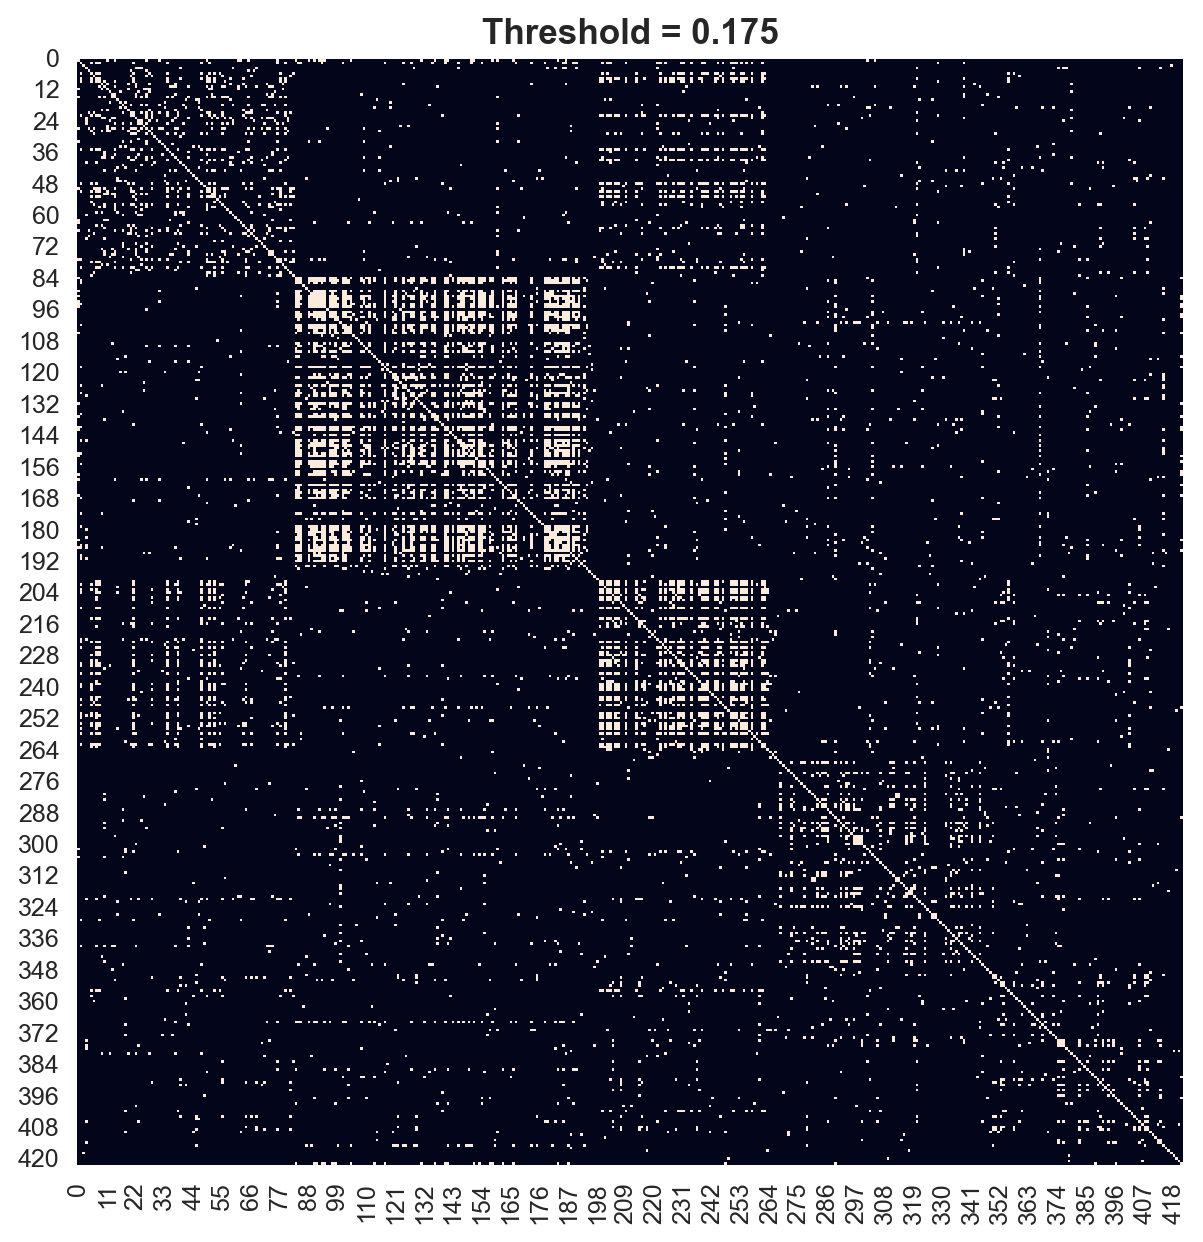

In [25]:
# for t in [0.

for t in [0.145, 0.155, 0.165, 0.175]:
    f,a = plt.subplots(1,1,figsize=(7,7))
    sns.heatmap(da_test<t, square=True, ax = a, cbar=False)
    a.set_title(f'Threshold = {t}', fontweight='semibold', fontsize=14)
    # f.suptitle('CNNVAE for top 5 peptides\n[ELAGIGILTV, GILGFVFTL, LLWNGPMAV, RAKFKQLL, YLQPRTFLL]', fontweight='semibold', y=0.9)
    f.tight_layout()

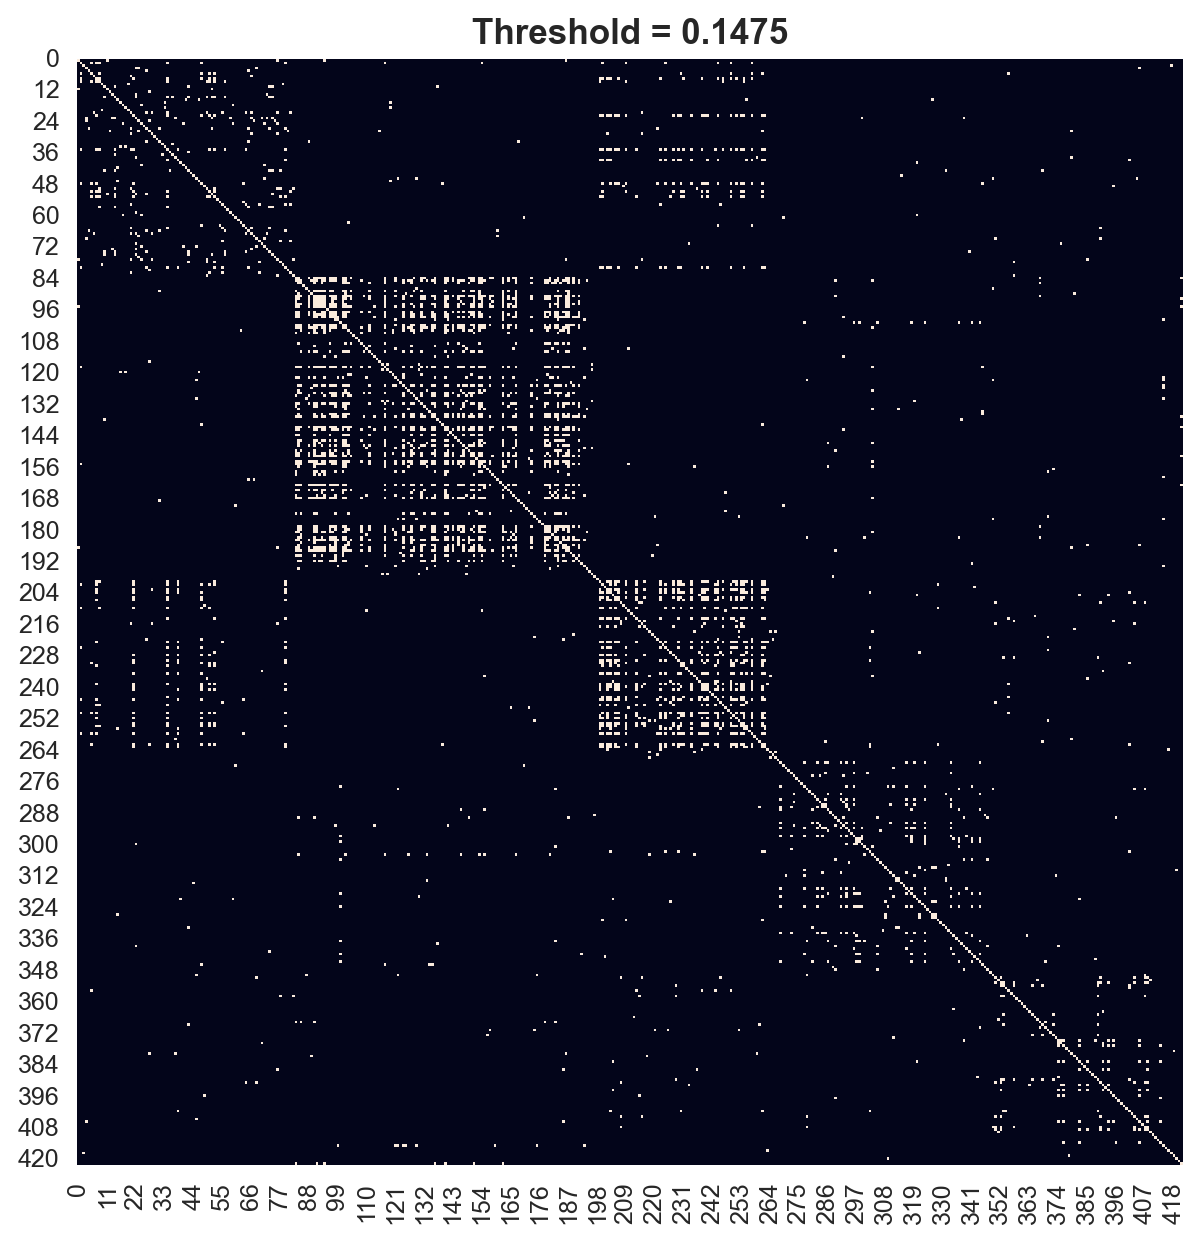

In [26]:
# for t in [0.
t=0.1475
f,a = plt.subplots(1,1,figsize=(7,7))
sns.heatmap(da_test<t, square=True, ax = a, cbar=False)
a.set_title(f'Threshold = {t}', fontweight='semibold', fontsize=14)
# f.suptitle('CNNVAE for top 5 peptides\n[ELAGIGILTV, GILGFVFTL, LLWNGPMAV, RAKFKQLL, YLQPRTFLL]', fontweight='semibold', y=0.9)
f.tight_layout()

### Unsub - heatmap test

In [419]:
# subsample to 4 and subsample a few
subsample = []
for p in tbcr_subset.peptide.unique():
    subsample.append(tbcr_subset.query('peptide==@p').sample(frac=1, random_state=13))
tbcr_nosub = pd.concat(subsample)
tbcr_nosub = tbcr_nosub[[str(x) for x in tbcr_nosub.index]+['binder','partition','raw_index','peptide','original_peptide']]
# Reset index to ordinal to match NetworkX tree just for this example
tbcr_nosub.reset_index(drop=True, inplace=True)
tbcr_nosub.columns = tbcr_nosub.index.tolist() + ['binder', 'partition', 'raw_index', 'peptide','original_peptide']
tbcr_nosub.groupby('peptide').count()

0    1    2    3    4    5    6    7    8    9  ...  640  641  \
peptide                                                       ...             
ELAGIGILTV   92   92   92   92   92   92   92   92   92   92  ...   92   92   
GILGFVFTL   233  233  233  233  233  233  233  233  233  233  ...  233  233   
LLWNGPMAV    75   75   75   75   75   75   75   75   75   75  ...   75   75   
RAKFKQLL    166  166  166  166  166  166  166  166  166  166  ...  166  166   
YLQPRTFLL    80   80   80   80   80   80   80   80   80   80  ...   80   80   

            642  643  644  645  binder  partition  raw_index  original_peptide  
peptide                                                                         
ELAGIGILTV   92   92   92   92      92         92         92                92  
GILGFVFTL   233  233  233  233     233        233        233               233  
LLWNGPMAV    75   75   75   75      75         75         75                75  
RAKFKQLL    166  166  166  166     166        166        166               166  
YLQPRTFLL    80   80   80   80      80         80         80                80  

[5 rows x 650 columns]

In [422]:
sorted = tbcr_nosub.sort_values('peptide')
sorted = sorted[list(sorted.index) + ['peptide','raw_index']]
sorted_vals = sorted[list(sorted.index)].values

### some pruning stats things

In [986]:
print('TBCR')
vals = tbcr_test[tbcr_test.index].values
vals[vals!=0].min(), vals.max(), vals.std(), vals.mean(), np.median(vals)
# Using distances
threshold = 0.145
for threshold in np.linspace(0.135, 0.16, 10):
    G = nx.Graph(vals)
    tree = nx.minimum_spanning_tree(G)
    tree_pruned = tree.copy()
    removed_edges = []
    for u,v in tree_pruned.edges():
        weight = tree_pruned.get_edge_data(u,v)['weight']
        if weight >=threshold:
            label1=tbcr_test.iloc[u]['peptide']
            label2=tbcr_test.iloc[v]['peptide']
            removed_edges.append((u,v, round(weight,4), int(label1==label2), label1, label2)) 
            tree_pruned.remove_edge(u,v)
    print('***')
    print(f'threshold:{threshold:.3f}\t\t',len(removed_edges), 'removed edges', f'\n{np.array([x[3] for x in removed_edges]).mean():.2%} of the removed edges were same-class')
    print('***')

TBCR
***
threshold:0.135		 51 removed edges 
25.49% of the removed edges were same-class
***
***
threshold:0.138		 44 removed edges 
25.00% of the removed edges were same-class
***
***
threshold:0.141		 35 removed edges 
22.86% of the removed edges were same-class
***
***
threshold:0.143		 31 removed edges 
19.35% of the removed edges were same-class
***
***
threshold:0.146		 25 removed edges 
20.00% of the removed edges were same-class
***
***
threshold:0.149		 22 removed edges 
18.18% of the removed edges were same-class
***
***
threshold:0.152		 17 removed edges 
23.53% of the removed edges were same-class
***
***
threshold:0.154		 16 removed edges 
25.00% of the removed edges were same-class
***
***
threshold:0.157		 13 removed edges 
23.08% of the removed edges were same-class
***
***
threshold:0.160		 8 removed edges 
25.00% of the removed edges were same-class
***


In [984]:
print('VAE')
vals = da_test # tbcr_test[tbcr_test.index].values
vals[vals!=0].min(), vals.max(), vals.std(), vals.mean(), np.median(vals)
# Using distances
threshold = 0.145
for threshold in np.linspace(0.155, 0.18, 10):
    G = nx.Graph(vals)
    tree = nx.minimum_spanning_tree(G)
    tree_pruned = tree.copy()
    removed_edges = []
    for u,v in tree_pruned.edges():
        weight = tree_pruned.get_edge_data(u,v)['weight']
        if weight >=threshold:
            label1=tbcr_test.iloc[u]['peptide']
            label2=tbcr_test.iloc[v]['peptide']
            removed_edges.append((u,v, round(weight,4), int(label1==label2), label1, label2)) 
            tree_pruned.remove_edge(u,v)
    print('***')
    print(f'threshold:{threshold:.3f}\t\t',len(removed_edges), 'removed edges', f'\n{np.array([x[3] for x in removed_edges]).mean():.2%} of the removed edges were same-class')
    print('***')

VAE
***
threshold:0.155		 60 removed edges 
38.33% of the removed edges were same-class
***
***
threshold:0.158		 49 removed edges 
38.78% of the removed edges were same-class
***
***
threshold:0.161		 38 removed edges 
42.11% of the removed edges were same-class
***
***
threshold:0.163		 31 removed edges 
41.94% of the removed edges were same-class
***
***
threshold:0.166		 27 removed edges 
48.15% of the removed edges were same-class
***
***
threshold:0.169		 22 removed edges 
40.91% of the removed edges were same-class
***
***
threshold:0.172		 15 removed edges 
46.67% of the removed edges were same-class
***
***
threshold:0.174		 12 removed edges 
41.67% of the removed edges were same-class
***
***
threshold:0.177		 8 removed edges 
25.00% of the removed edges were same-class
***
***
threshold:0.180		 8 removed edges 
25.00% of the removed edges were same-class
***


In [985]:
print('Aggregated')
vals = da_agg2 # tbcr_test[tbcr_test.index].values
vals[vals!=0].min(), vals.max(), vals.std(), vals.mean(), np.median(vals)
# Using distances
threshold = 0.145
for threshold in np.linspace(0.28, 0.32, 10):
    G = nx.Graph(vals)
    tree = nx.minimum_spanning_tree(G)
    tree_pruned = tree.copy()
    removed_edges = []
    for u,v in tree_pruned.edges():
        weight = tree_pruned.get_edge_data(u,v)['weight']
        if weight >=threshold:
            label1=tbcr_test.iloc[u]['peptide']
            label2=tbcr_test.iloc[v]['peptide']
            removed_edges.append((u,v, round(weight,4), int(label1==label2), label1, label2)) 
            tree_pruned.remove_edge(u,v)
    print('***')
    print(f'threshold:{threshold:.3f}\t\t',len(removed_edges), 'removed edges', f'\n{np.array([x[3] for x in removed_edges]).mean():.2%} of the removed edges were same-class')
    print('***')

Aggregated
***
threshold:0.280		 57 removed edges 
31.58% of the removed edges were same-class
***
***
threshold:0.284		 49 removed edges 
30.61% of the removed edges were same-class
***
***
threshold:0.289		 42 removed edges 
30.95% of the removed edges were same-class
***
***
threshold:0.293		 33 removed edges 
33.33% of the removed edges were same-class
***
***
threshold:0.298		 28 removed edges 
35.71% of the removed edges were same-class
***
***
threshold:0.302		 19 removed edges 
36.84% of the removed edges were same-class
***
***
threshold:0.307		 15 removed edges 
26.67% of the removed edges were same-class
***
***
threshold:0.311		 12 removed edges 
16.67% of the removed edges were same-class
***
***
threshold:0.316		 9 removed edges 
22.22% of the removed edges were same-class
***
***
threshold:0.320		 7 removed edges 
14.29% of the removed edges were same-class
***


# MST / CC

In [72]:
def prune_by_distance(tree, threshold, prune_node=True, labels=None):
    tree_pruned = tree.copy()
    removed_edges = []
    
    for u,v in tree_pruned.edges():
        weight = tree_pruned.get_edge_data(u,v)['weight']
        if weight>=threshold: #assuming weight is a distance and not a similarity
            if labels is not None:
                l1=labels[u]
                l2=labels[v]
                same_label = l1==l2 if labels is not None else np.nan
            removed_edges.append(u,v, round(weight,4), same_label)
            tree_pruned.remove_edge(u,v)
    if prune_node:
        nodes_to_remove = list(nx.isolates(tree_pruned))
        tree_pruned.remove_nodes_from(nodes_to_remove)    
    print(f'***\nbefore pruning : {len(tree.edges())} edges, {len(tree.nodes())} nodes\n***')
    print(f'***\nafter pruning : {len(tree_pruned.edges())} edges, {len(tree_pruned.nodes())} nodes\n***')
    print(len(removed_edges), 'removed edges', f'\n{np.array([x[3] for x in removed_edges]).mean():.2%} of the removed edges were actually same-class')
    return tree_pruned, removed_edges

In [87]:
vals = tbcr_test[tbcr_test.index].values
labels = tbcr_test['peptide'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

print(vals[vals!=0].min(), vals.max(), vals.std(), vals.mean(), np.median(vals)) 
# Using distances
G = nx.Graph(vals)
for i, node in enumerate(G.nodes()):
    G.nodes[node]['peptide'] = labels[i]
    
tree = nx.minimum_spanning_tree(G)
tree_pruned = tree.copy()
threshold = 0.13
removed_edges = []
for u,v in tree_pruned.edges():
    weight = tree_pruned.get_edge_data(u,v)['weight']
    if weight >=threshold:
        label1=tbcr_test.iloc[u]['peptide']
        label2=tbcr_test.iloc[v]['peptide']
        removed_edges.append((u,v, round(weight,4), int(label1==label2), label1, label2)) 
        tree_pruned.remove_edge(u,v)

nodes_to_remove=list(nx.isolates(tree_pruned))
tree_pruned.remove_nodes_from(nodes_to_remove)
print(f'***\nbefore pruning : {len(tree.edges())} edges, {len(tree.nodes())} nodes\n***')
print(f'***\nafter pruning : {len(tree_pruned.edges())} edges, {len(tree_pruned.nodes())} nodes\n***')
print(len(removed_edges), 'removed edges', f'\n{np.array([x[3] for x in removed_edges]).mean():.2%} of the removed edges were actually same-class')
print('***\n')
print(removed_edges)
print(tree_pruned.edges())
color_map = {k:v for k,v in zip(sorted(np.unique(labels)), sns.color_palette('tab10', len(np.unique(labels))))}


0.0355119166666666 0.2906513333333334 0.027530748383427613 0.1814250393793565 0.18264616666666655
***
before pruning : 421 edges, 422 nodes
***
***
after pruning : 347 edges, 352 nodes
***
74 removed edges 
27.03% of the removed edges were actually same-class
***

[(0, 373, 0.1381, 0, 'ELAGIGILTV', 'YLQPRTFLL'), (2, 417, 0.1493, 0, 'ELAGIGILTV', 'YLQPRTFLL'), (20, 123, 0.1512, 0, 'ELAGIGILTV', 'GILGFVFTL'), (25, 187, 0.1513, 0, 'ELAGIGILTV', 'GILGFVFTL'), (34, 142, 0.1302, 0, 'ELAGIGILTV', 'GILGFVFTL'), (43, 243, 0.1321, 0, 'ELAGIGILTV', 'LLWNGPMAV'), (43, 314, 0.1332, 0, 'ELAGIGILTV', 'RAKFKQLL'), (47, 212, 0.1434, 0, 'ELAGIGILTV', 'LLWNGPMAV'), (48, 177, 0.1392, 0, 'ELAGIGILTV', 'GILGFVFTL'), (52, 335, 0.1307, 0, 'ELAGIGILTV', 'RAKFKQLL'), (53, 189, 0.1452, 0, 'ELAGIGILTV', 'GILGFVFTL'), (60, 207, 0.1305, 0, 'ELAGIGILTV', 'LLWNGPMAV'), (71, 417, 0.1341, 0, 'ELAGIGILTV', 'YLQPRTFLL'), (73, 176, 0.139, 0, 'ELAGIGILTV', 'GILGFVFTL'), (86, 398, 0.1586, 0, 'GILGFVFTL', 'YLQPRTFLL'), (100,

In [69]:
tbcr_test.to_csv('../output/240606_nettcr_distance_matrix_5peptides_tbcralign.txt')

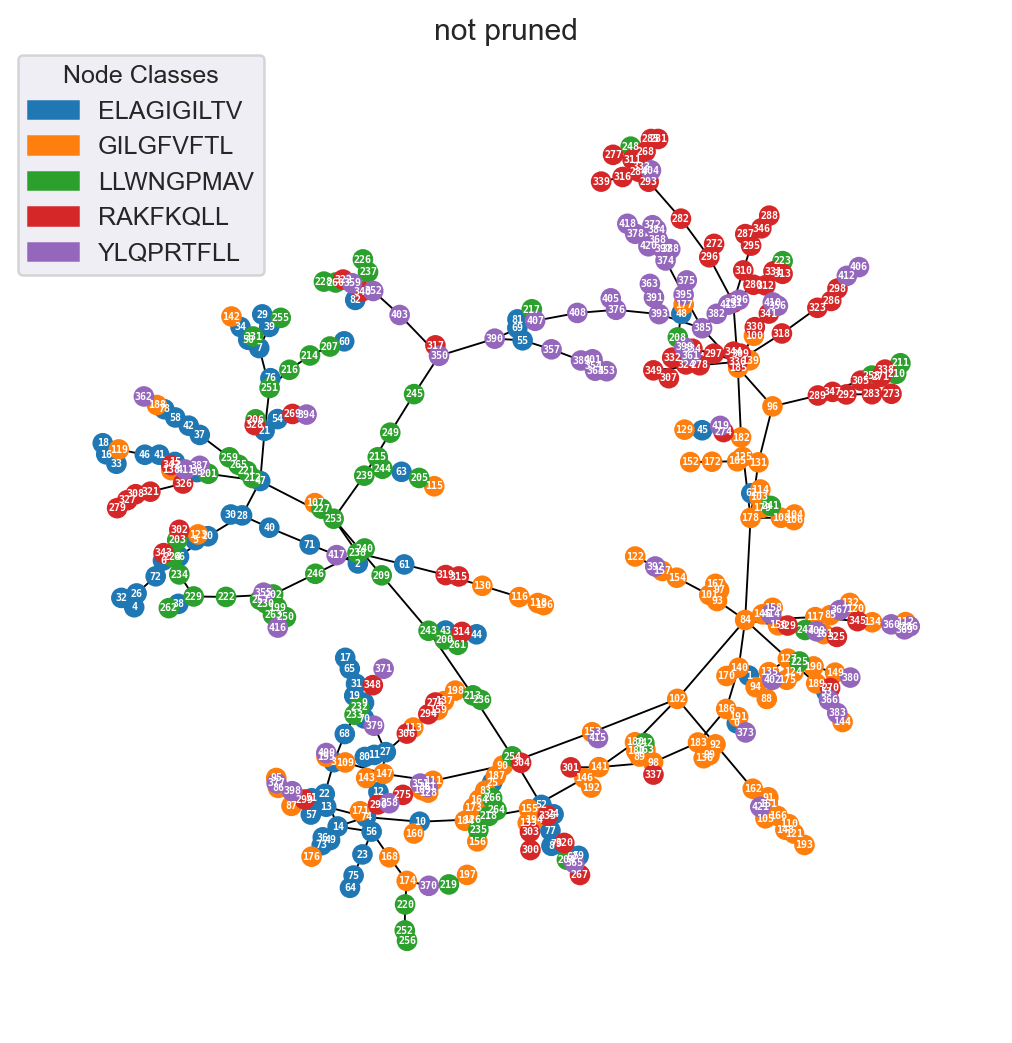

In [76]:
# unpruned tree plot
from matplotlib.patches import Patch

sns.set_style('darkgrid')
# Visualize the graph and the minimum spanning tree
f,a = plt.subplots(1,1, figsize=(7,7))
pos = nx.spring_layout(tree, iterations=300, k=0.1, threshold=1e-5, seed=13)
node_colors = [color_map[tree.nodes[node]['peptide']] for node in tree.nodes()]
nx.draw_networkx_nodes(tree, pos, node_color=node_colors, node_size=52.5, ax=a) # nx.draw_networkx_edges(G, pos, edge_color="grey")
nx.draw_networkx_labels(tree, pos, font_size=4, font_color='w', font_weight='semibold', font_family="monospace")
# nx.draw_networkx_edge_labels(
#     G, pos, edge_labels={(u, v): round(d["weight"],3) for u, v, d in tree.edges(data=True)}
# )
nx.draw_networkx_edges(tree, pos, edge_color="k", width=0.75)
# Create a legend
legend_labels = {k: color_map[k] for k in sorted(color_map.keys())}  # Sorted keys for consistent order
patches = [Patch(color=color, label=f'{label}') for label, color in legend_labels.items()]
plt.legend(handles=patches, title='Node Classes', loc='best', borderaxespad=0.)
a.set_title('not pruned')
plt.axis("off")
plt.show()

In [ ]:
# TAKE MATRIX
# TAKE THRESHOLD
# BINARIZE IT
# USE BINARY MATRIX TO DO MST AND/OR CLUSTERING

In [30]:
tree_pruned.nodes[210], tree_pruned.nodes[271], tree_pruned.get_edge_data(210,271)

({'peptide': 'LLWNGPMAV'},
 {'peptide': 'RAKFKQLL'},
 {'weight': 0.1271555833333333})

In [122]:
tree_pruned.adj[0]

AtlasView({186: {'weight': 0.1195195}})

In [123]:
nx.to_numpy_array(tree_pruned)[0][186]

0.0

In [121]:
nx.to_dict_of_dicts(tree_pruned)

{0: {186: {'weight': 0.1195195}},
 1: {170: {'weight': 0.0990049166666667}, 135: {'weight': 0.1024045833333332}},
 3: {22: {'weight': 0.10088225}, 68: {'weight': 0.1138086666666665}},
 4: {26: {'weight': 0.1191764166666665}},
 5: {20: {'weight': 0.1047018333333333}},
 6: {66: {'weight': 0.1142158333333333}},
 7: {34: {'weight': 0.0610680833333333},
  251: {'weight': 0.0692939166666666},
  39: {'weight': 0.0908059166666666},
  50: {'weight': 0.09401025},
  231: {'weight': 0.1087683333333333}},
 8: {77: {'weight': 0.1129132499999999}},
 9: {19: {'weight': 0.1021757499999999},
  31: {'weight': 0.1025390833333332},
  379: {'weight': 0.1064949166666666}},
 10: {74: {'weight': 0.0905360833333333},
  126: {'weight': 0.10167025},
  160: {'weight': 0.1027916666666666}},
 11: {27: {'weight': 0.1094702500000001}, 80: {'weight': 0.1112656666666667}},
 12: {27: {'weight': 0.0949009166666666}, 56: {'weight': 0.0969857499999999}},
 13: {57: {'weight': 0.0952100833333333},
  398: {'weight': 0.0989755}

In [105]:
tree_pruned.adj[90], tree_pruned.adj[282], tree_pruned.adj[178]

(AtlasView({83: {'weight': 0.0786348333333334}, 153: {'weight': 0.0524728333333333}, 111: {'weight': 0.0773280833333333}, 187: {'weight': 0.08814525}}),
 AtlasView({293: {'weight': 0.0697329999999999}, 296: {'weight': 0.0794400833333334}}),
 AtlasView({84: {'weight': 0.0730207499999999}, 108: {'weight': 0.0673723333333332}, 131: {'weight': 0.0849363333333332}, 182: {'weight': 0.0752589166666667}, 179: {'weight': 0.0798478333333333}}))

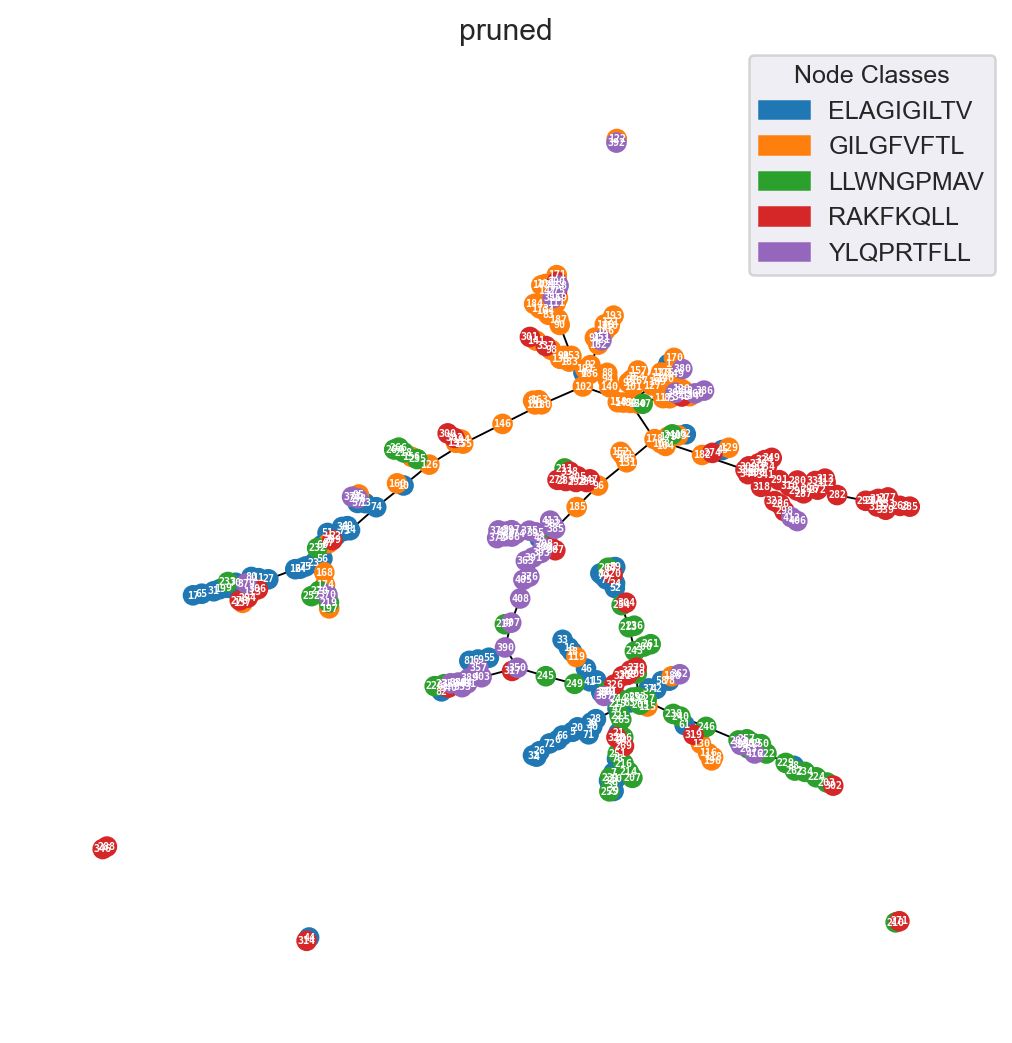

In [138]:
sns.set_style('darkgrid')
# Visualize the graph and the minimum spanning tree
f,a = plt.subplots(1,1, figsize=(7,7))
pos = nx.spring_layout(tree_pruned, iterations=300, threshold=1e-5, seed=1, scale=0.9,  k=0.05, dim=2)
node_colors = [color_map[tree_pruned.nodes[node]['peptide']] for node in tree_pruned.nodes()]
nx.draw_networkx_nodes(tree_pruned, pos, node_color=node_colors, node_size=52.5, ax=a) # nx.draw_networkx_edges(G, pos, edge_color="grey")
nx.draw_networkx_labels(tree_pruned, pos, font_size=4, font_color='w', font_weight='semibold', font_family="monospace")
# nx.draw_networkx_edge_labels(
#     G, pos, edge_labels={(u, v): round(d["weight"],3) for u, v, d in tree.edges(data=True)}
# )
nx.draw_networkx_edges(tree_pruned, pos, edge_color="k", width=0.75)
# Create a legend
legend_labels = {k: color_map[k] for k in sorted(color_map.keys())}  # Sorted keys for consistent order
patches = [Patch(color=color, label=f'{label}') for label, color in legend_labels.items()]
plt.legend(handles=patches, title='Node Classes', loc='best', borderaxespad=0.)
# Find bottleneck score ; with centrality AND connectivity
a.set_title('pruned')
plt.axis("off")
plt.show()

In [145]:
list(tree_pruned.neighbors(182))

[178, 336, 274]

In [156]:
list(tree_pruned.neighbors(336))

[100, 182, 278, 291, 297, 309, 318, 344]

In [146]:
tree_pruned.get_edge_data(182, 274)

{'weight': 0.1107602499999999}

In [154]:
tree_pruned.nodes(data=True)[274]

{'peptide': 'RAKFKQLL'}

In [148]:
tree_pruned.nodes()

NodeView((0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 108, 109, 110, 111, 113, 115, 116, 117, 118, 119, 120, 121, 122, 124, 126, 127, 129, 130, 131, 132, 133, 134, 135, 136, 137, 140, 141, 143, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 196, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 224, 226, 227, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 243, 244, 245, 246, 247, 249

In [147]:
tree_pruned.get_edge_data(182, 336)

{'weight': 0.0833748333333334}

In [86]:
tree.get_edge_data(282,90)

In [81]:
tree_pruned.get_no(282, 90)

In [78]:
tbcr_test.iloc[[90,153,282, 187]][[90,153,282, 187]+['peptide']]

90       153       282       187    peptide
204  0.175198  0.111022  0.127209  0.194819  GILGFVFTL
225  0.173516  0.088448  0.133791  0.189114  GILGFVFTL
55   0.165549  0.170877  0.150695  0.211899   RAKFKQLL
154  0.170663  0.119691  0.170517  0.181886  GILGFVFTL

# Thresholding matrix

In [35]:
tbcr_da = tbcr_test.iloc[:, :len(tbcr_test)].values
tbcr_labels = tbcr_test['peptide'].values
tbcr_enc = LabelEncoder()
tbcr_encoded_labels = tbcr_enc.fit_transform(tbcr_labels)

vae_da = dm_test.iloc[:, :len(dm_test)].values
vae_labels = dm_test['peptide'].values
vae_enc = LabelEncoder()
vae_encoded_labels = vae_enc.fit_transform(vae_labels)

In [37]:
tbcr_cluster = cluster_all_thresholds(tbcr_da, torch.rand([len(tbcr_da), 1]), tbcr_labels, tbcr_encoded_labels, tbcr_enc, n_jobs=8)
vae_cluster = cluster_all_thresholds(vae_da, torch.rand([len(vae_da), 1]), vae_labels, vae_encoded_labels, vae_enc, n_jobs=8)

HERE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 147.90it/s]


HERE


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 145.52it/s]


In [ ]:

# Here, do a run ith only the best
def plot_pipeline(results, b, plot_title='None', fig_fn=None, filter=None, palette=None, more=False,
                  add_cluster_size=False):
    runs = pd.concat([b, results])
    # plotting options
    if filter is None:
        filter = ['TBCRalign', 'KernelSim', 'tcrdist3'] + list(results.input_type.unique())

    if palette is None:
        palette = 'gnuplot2'
    if more:
        palette = get_palette(palette, n_colors=len(filter) - 3)
    else:
        palette = sns.color_palette(palette, n_colors=len(filter) - 3)

    sns.set_palette(palette)
    f, a = plt.subplots(1, 1, figsize=(9, 9))
    a.set_xlim([0, 1])
    a.set_ylim([0, 1])
    a.set_xlabel('Retention', fontweight='semibold', fontsize=14)
    a.set_ylabel('Avg Purity', fontweight='semibold', fontsize=14)
    # Setting major ticks
    major_ticks = np.arange(0, 1.1, 0.1)
    a.set_xticks(major_ticks)
    a.set_yticks(major_ticks)
    # Setting minor ticks
    minor_ticks = np.arange(0, 1.1, 0.05)
    a.set_xticks(minor_ticks, minor=True)
    a.set_yticks(minor_ticks, minor=True)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    print(runs.duplicated().any())
    if add_cluster_size:
        ax2 = a.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_yscale('log', base=2)

    for i, input_type in enumerate(filter):
        query = runs.query('input_type==@input_type')
        retentions = query['retention'].values[1:-1]
        purities = query['mean_purity'].values[1:-1]
        print(input_type, '\t', round(get_retpur_auc(retentions, purities), 4))
        ls = '-' if i % 2 == 0 else '--'
        if add_cluster_size:
            cluster_sizes = query['mean_cluster_size'].values[1:-1]
        # Plotting baselines with fixed styles colors etc
        if input_type == "TBCRalign":
            a.plot(retentions, purities, label='TBCRalign', ls=':', c='k', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='x', lw=0.5, s=8, c='k')
        elif input_type == "KernelSim":
            a.plot(retentions, purities, label='KernelSim', ls=':', c='m', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='v', lw=0.1, s=8, c='m')
        elif input_type == "tcrdist3":
            a.plot(retentions, purities, label='tcrdist3', ls=':', c='y', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='*', lw=0.1, s=8, c='y')
        # Plotting the actual things
        else:
            a.plot(retentions, purities, label=input_type.lstrip('_').replace('_', ' ').replace('checkpoint best', ''),
                   ls=ls, lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='+', lw=1.15, s=12)

    a.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
    a.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
    a.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')

    a.legend(title='distance matrix', title_fontproperties={'size': 14, 'weight': 'semibold'},
             prop={'weight': 'semibold', 'size': 12})

    f.suptitle(f'{plot_title}', fontweight='semibold', fontsize=15)
    f.tight_layout()
    if fig_fn is not None:
        f.savefig(f'../output/240411_ClusteringTests/{fig_fn}.png', dpi=200)
    return runs



In [48]:
def plot_pipeline_here(runs, title=None, fn=None, palette='gnuplot2', add_clustersize=False):
    # plotting options
    sns.set_palette(palette, n_colors=len(runs.input_type.unique()))
    f, a = plt.subplots(1, 1, figsize=(9, 9))
    a.set_xlim([0, 1])
    a.set_ylim([0, 1])
    a.set_xlabel('Retention', fontweight='semibold', fontsize=14)
    a.set_ylabel('Avg Purity', fontweight='semibold', fontsize=14)
    # Setting major ticks
    major_ticks = np.arange(0, 1.1, 0.1)
    a.set_xticks(major_ticks)
    a.set_yticks(major_ticks)
    # Setting minor ticks
    minor_ticks = np.arange(0, 1.1, 0.05)
    a.set_xticks(minor_ticks, minor=True)
    a.set_yticks(minor_ticks, minor=True)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    if add_cluster_size:
        ax2 = a.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_yscale('log', base=2)
        
    for input_type in runs.input_type.unique():
        query = runs.query('input_type==@input_type')
        retentions = query['retention'][1:-1].values
        purities = query['mean_purity'][1:-1].values
        if add_clustersize:
            cluster_sizes = query['mean_cluster_size'].values[1:-1]
            
        if input_type == "TBCRalign":
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls=':', c='g', lw=1)
            ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='x', lw=0.5, s=8, c='k')

        elif input_type == "tcrdist3":
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls=':', c='m', lw=1)
            ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='x', lw=0.5, s=8, c='k')

        else:
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls='--', lw=1.1)
            ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='x', lw=0.5, s=8, c='k')


    a.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
    a.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
    a.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')

    a.legend(title='distance matrix', title_fontproperties={'size': 14, 'weight': 'semibold'},
             prop={'weight': 'semibold', 'size': 12}, loc='lower left')
    f.suptitle(f'{title}', fontweight='semibold', fontsize=15)
    f.tight_layout()
    if fn is not None:
        f.savefig(f'{fn}.png', dpi=200)

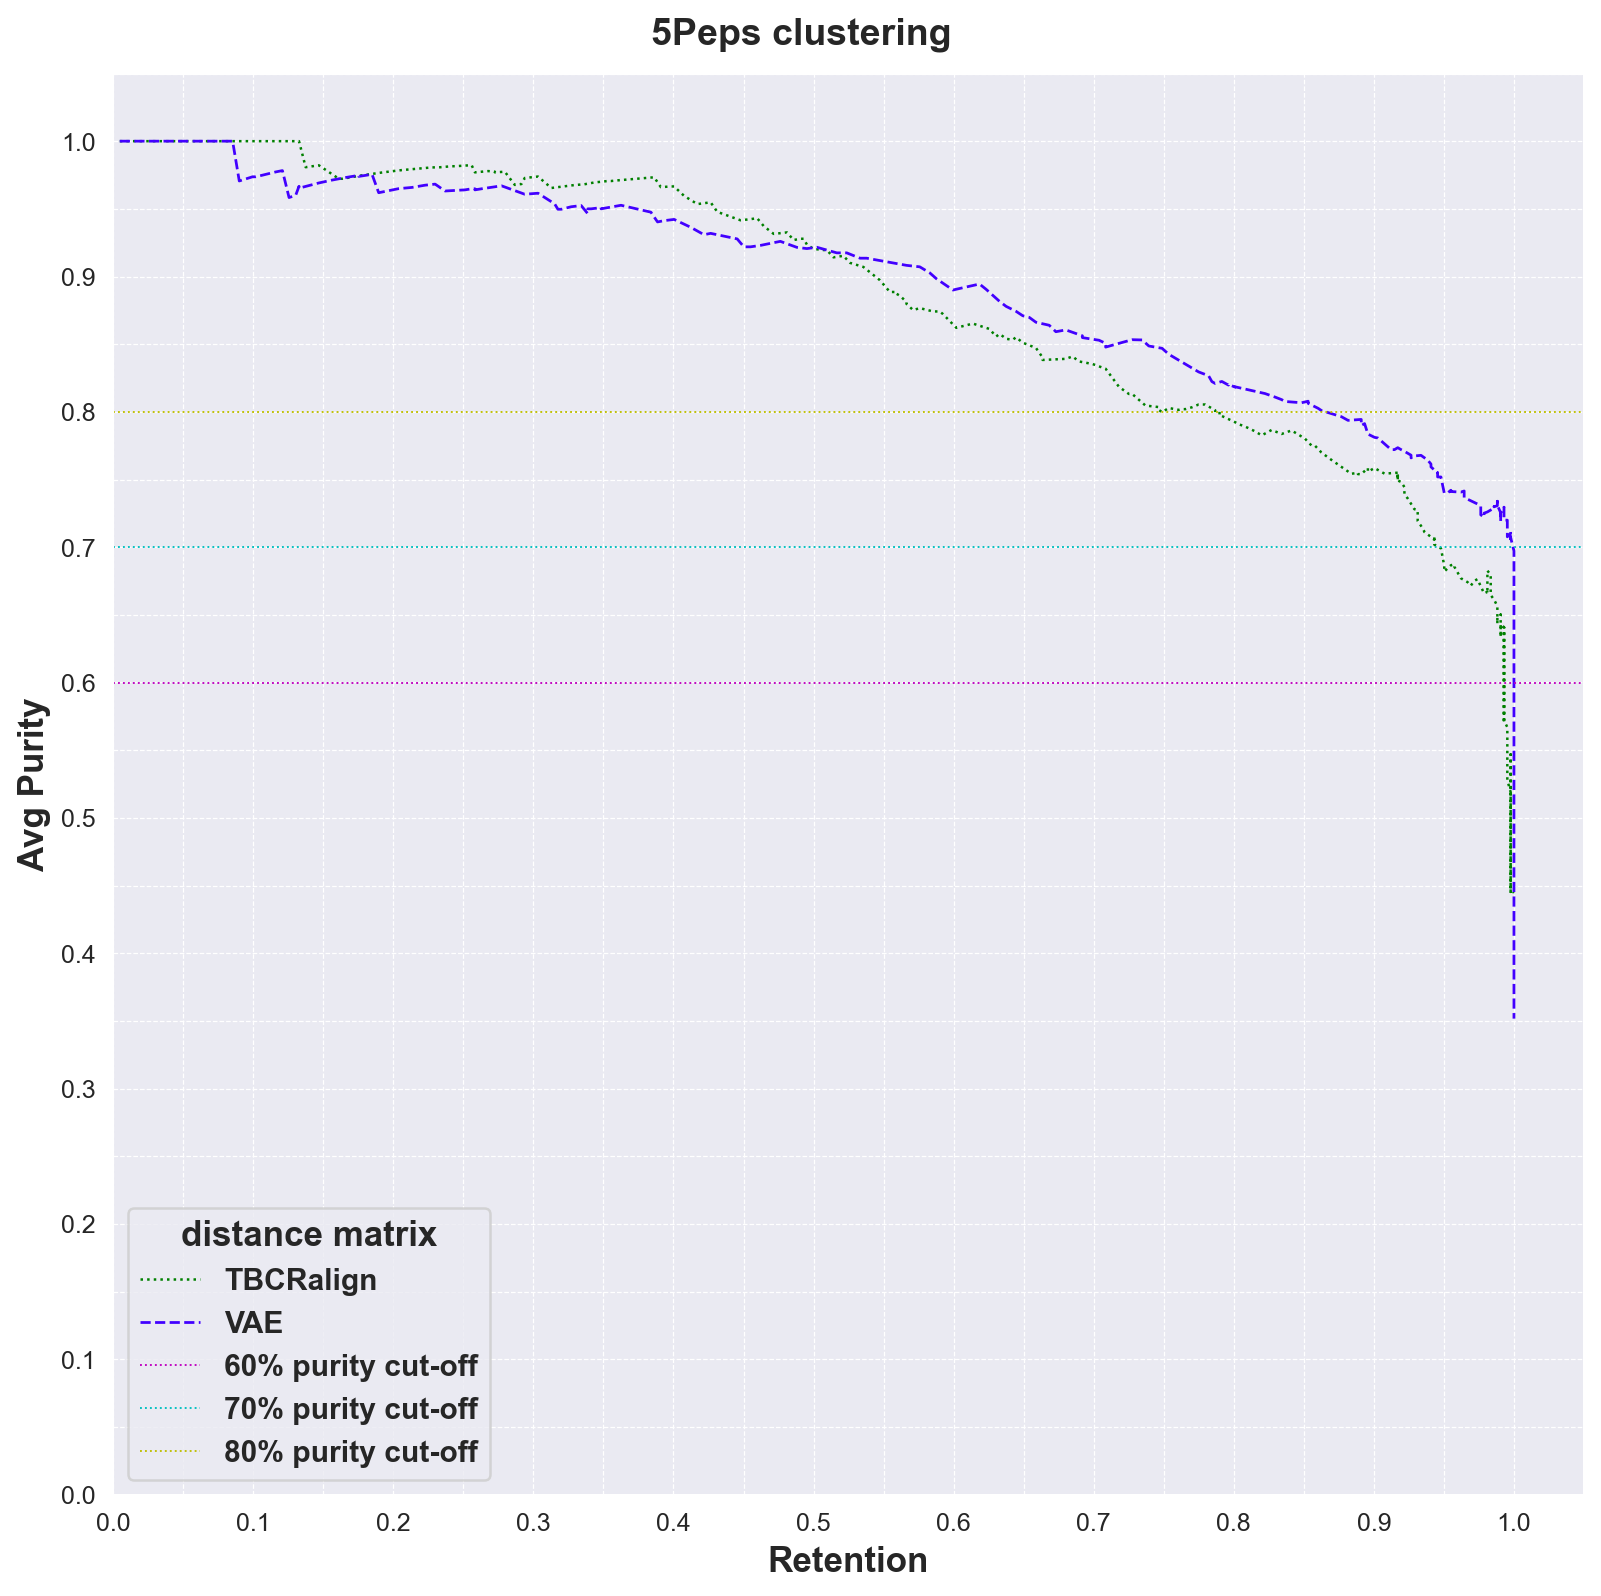

In [49]:
plot_pipeline_here(pd.concat([tbcr_cluster.assign(input_type='TBCRalign'), 
                             vae_cluster.assign(input_type='vae'.upper())]), title='5Peps clustering')

# Bottleneck problem

In [280]:
def prune_by_distance(tree, threshold, prune_node=True, labels=None, verbose=False):
    tree_pruned = tree.copy()
    removed_edges = []
    
    for u,v in tree_pruned.edges():
        weight = tree_pruned.get_edge_data(u,v)['weight']
        if weight>=threshold: #assuming weight is a distance and not a similarity
            if labels is not None:
                l1=labels[u]
                l2=labels[v]
                same_label = l1==l2 if labels is not None else np.nan
            removed_edges.append((u,v, round(weight,4), same_label))
            tree_pruned.remove_edge(u,v)
    if prune_node:
        nodes_to_remove = list(nx.isolates(tree_pruned))
        tree_pruned.remove_nodes_from(nodes_to_remove)    
    if verbose:
        print(f'***\nbefore pruning : {len(tree.edges())} edges, {len(tree.nodes())} nodes\n***')
        print(f'***\nafter pruning : {len(tree_pruned.edges())} edges, {len(tree_pruned.nodes())} nodes\n***')
        print(len(removed_edges), 'removed edges', f'\n{np.array([x[3] for x in removed_edges]).mean():.2%} of the removed edges were actually same-class')
    return tree_pruned, removed_edges


def draw_mst_spring(tree, color_map, title=None, iterations=300, threshold=1e-5, scale=0.9, k=0.05, dim=2, seed=13):
    sns.set_style('darkgrid')
    # Visualize the graph and the minimum spanning tree
    f,a = plt.subplots(1,1, figsize=(8,8))
    pos = nx.spring_layout(tree, iterations=iterations, threshold=threshold, seed=seed, scale=scale,  k=k, dim=dim)
    node_colors = [color_map[tree.nodes[node]['peptide']] for node in tree.nodes()]
    nx.draw_networkx_nodes(tree, pos, node_color=node_colors, node_size=52.5, ax=a) # nx.draw_networkx_edges(G, pos, edge_color="grey")
    nx.draw_networkx_labels(tree, pos, font_size=4, font_color='w', font_weight='semibold', font_family="monospace")
    nx.draw_networkx_edges(tree, pos, edge_color="k", width=0.75)
    # Create a legend
    legend_labels = {k: color_map[k] for k in sorted(color_map.keys())}  # Sorted keys for consistent order
    patches = [Patch(color=color, label=f'{label}') for label, color in legend_labels.items()]
    plt.legend(handles=patches, title='Node Classes', loc='best', borderaxespad=0.)
    # Find bottleneck score ; with centrality AND connectivity
    if title is not None:
        a.set_title(title)
    plt.axis("off")
    plt.show()

In [321]:
dm_test.columns[-6:]

Index([321, 298, 'binder', 'partition', 'raw_index', 'peptide'], dtype='object')

In [518]:
vals = dm_test[dm_test.index].values
labels = dm_test['peptide'].values
raw_index = dm_test['raw_index'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
print('Values stats')
print(vals[vals!=0].min(), vals.max(), vals.std(), vals.mean(), np.median(vals)) 
print('\n')
# Using distances
G = nx.Graph(vals)
for i, node in enumerate(G.nodes()):
    G.nodes[node]['peptide'] = labels[i]
    # Used to recover the datapoints from the distance matrix
    G.nodes[node]['raw_index'] = raw_index[i]

# First find a threshold to do the initial pruning by distance
res = []
tree = nx.minimum_spanning_tree(G)
for t in np.linspace(0.140, 0.155, 100):
    tree_pruned, removed_edges = prune_by_distance(tree, t, prune_node=True, labels = labels, verbose=False)
    z = np.mean([int(x[-1]) for x in removed_edges])
    # print(f'Threshold:\t{t:.5f}\terror:\t{z:.2%}\tN={len(removed_edges)}')
    res.append({'threshold':t, 'error':z, 'n_removed':len(removed_edges)})
    # print(f'Removed edges: \n', removed_edges, '\n\n')
    # print(f'Remaining edges: \n', tree_pruned.edges(), '\n\n')
errors = pd.DataFrame(res).drop_duplicates(subset=['error','n_removed']).sort_values('error')
display(errors.head())
color_map = {k:v for k,v in zip(sorted(np.unique(labels)), sns.color_palette('tab10', len(np.unique(labels))))}

Values stats
0.019308388 0.40348476 0.04150142 0.24371497 0.2476097




threshold     error  n_removed
72   0.150909  0.364865         74
67   0.150152  0.367089         79
85   0.152879  0.367647         68
76   0.151515  0.369863         73
82   0.152424  0.371429         70

In [519]:
errors

threshold     error  n_removed
72   0.150909  0.364865         74
67   0.150152  0.367089         79
85   0.152879  0.367647         68
76   0.151515  0.369863         73
82   0.152424  0.371429         70
69   0.150455  0.371795         78
86   0.153030  0.373134         67
71   0.150758  0.373333         75
66   0.150000  0.375000         80
88   0.153333  0.375000         64
70   0.150606  0.376623         77
96   0.154545  0.377049         61
81   0.152273  0.380282         71
91   0.153788  0.380952         63
62   0.149394  0.382716         81
97   0.154697  0.383333         60
94   0.154242  0.387097         62
59   0.148939  0.390244         82
57   0.148636  0.397590         83
54   0.148182  0.400000         85
44   0.146667  0.404494         89
53   0.148030  0.406977         86
35   0.145303  0.408602         93
46   0.146970  0.409091         88
25   0.143788  0.410000        100
34   0.145152  0.410526         95
42   0.146364  0.411111         90
36   0.145455  0.413043         92
49   0.147424  0.413793         87
26   0.143939  0.414141         99
24   0.143636  0.415842        101
32   0.144848  0.416667         96
41   0.146212  0.417582         91
20   0.143030  0.421569        102
28   0.144242  0.422680         97
9    0.141364  0.424779        113
19   0.142879  0.427184        103
0    0.140000  0.427350        117
10   0.141515  0.428571        112
1    0.140152  0.431034        116
4    0.140606  0.434783        115
12   0.141818  0.436364        110
18   0.142727  0.438095        105
16   0.142424  0.439252        107
13   0.141970  0.440367        109
17   0.142576  0.443396        106
14   0.142121  0.444444        108

***
before pruning : 421 edges, 422 nodes
***
***
after pruning : 347 edges, 356 nodes
***
74 removed edges 
36.49% of the removed edges were actually same-class


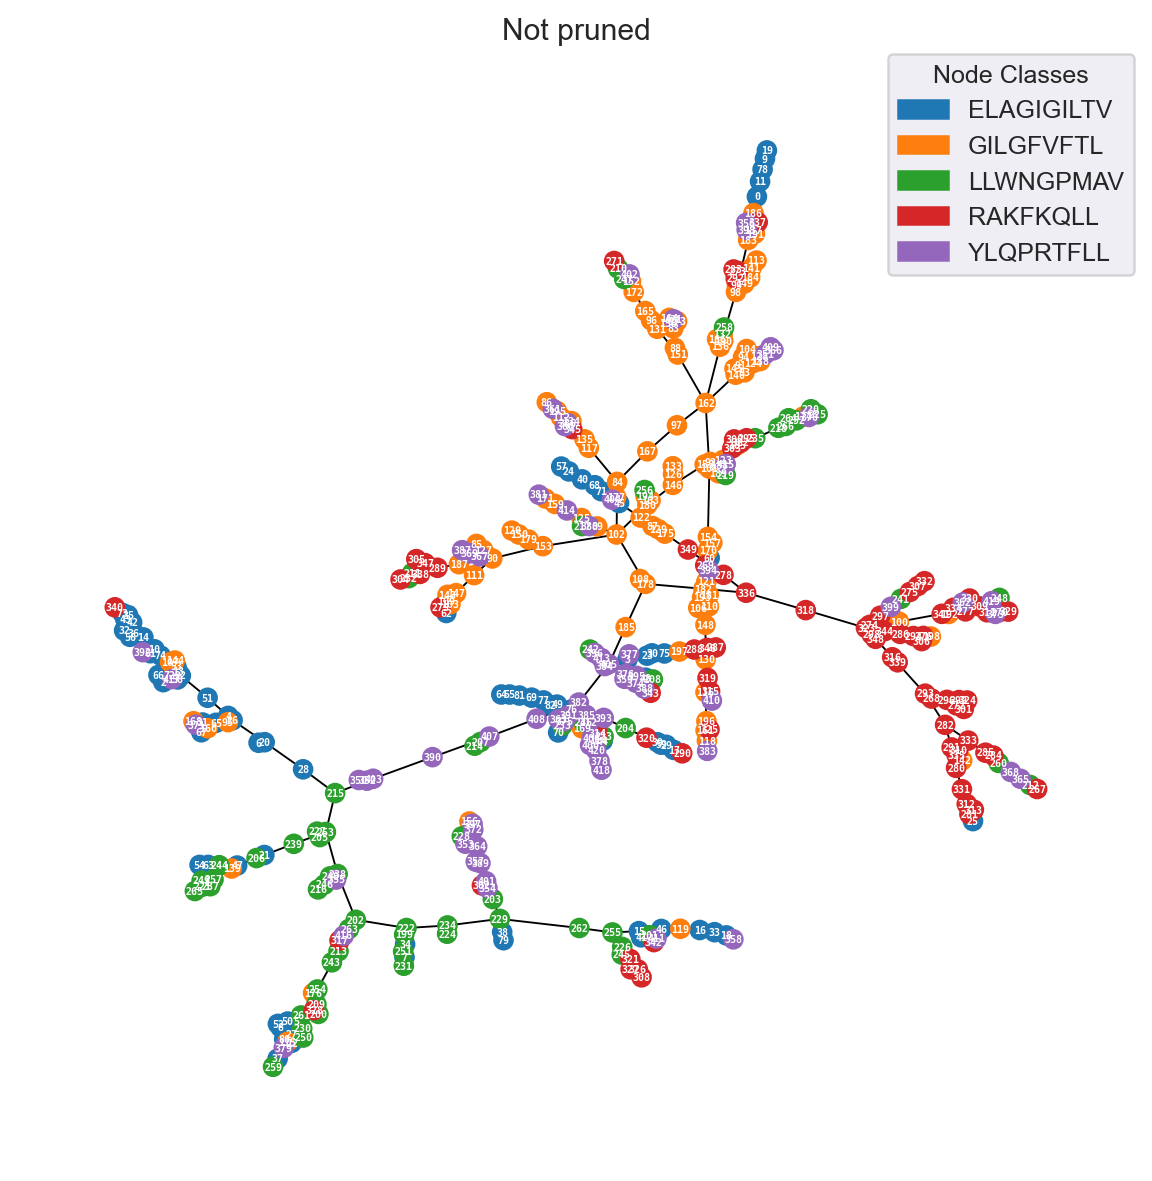

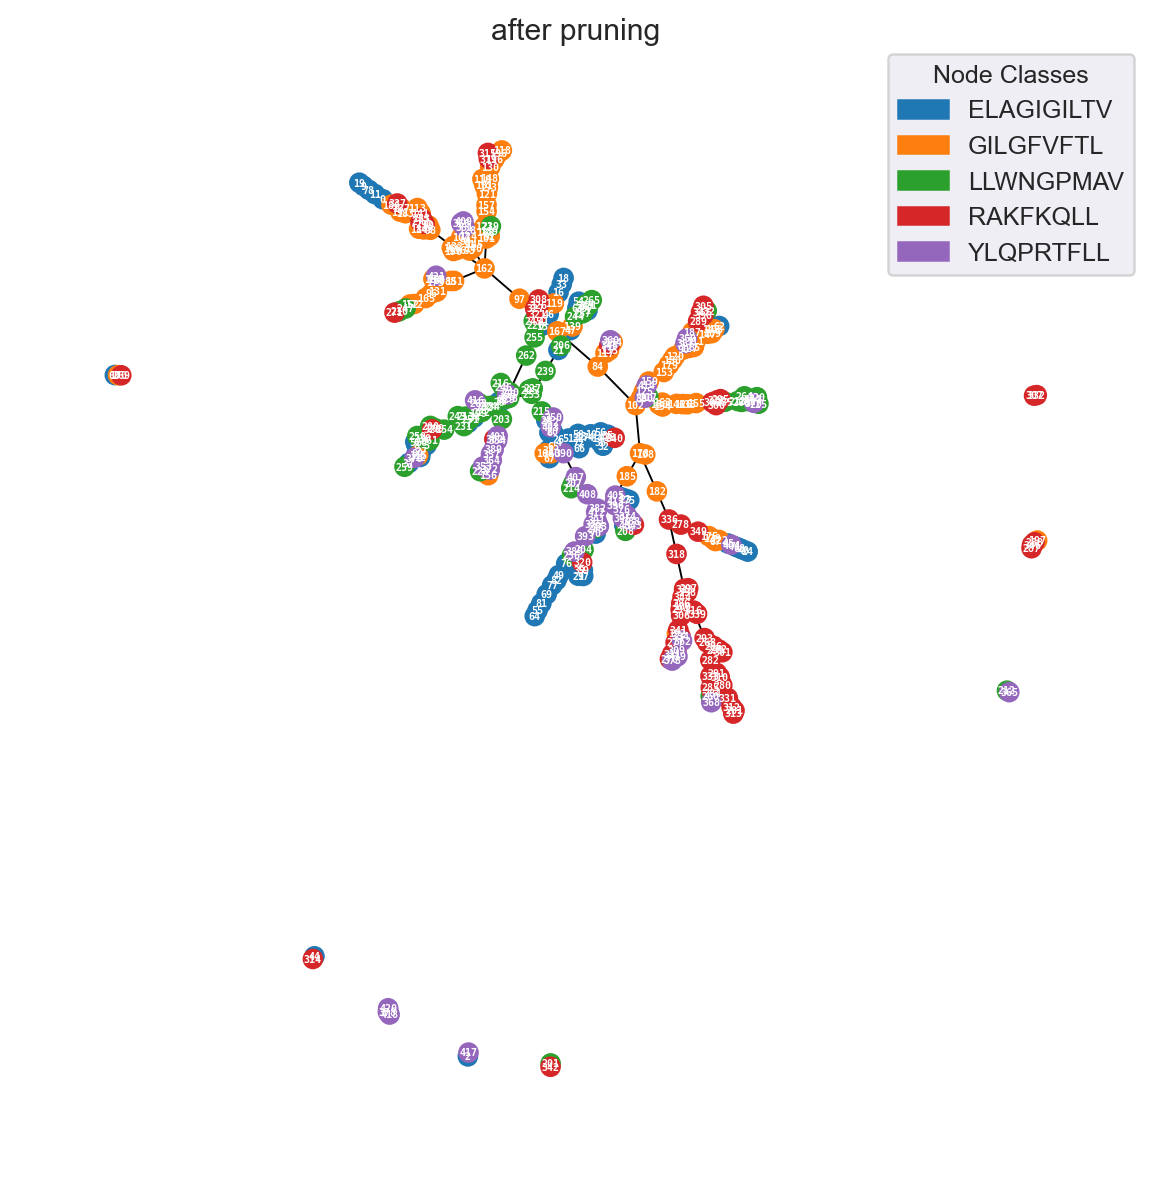

In [323]:
# Do a pruning and check the plot
t = 0.150783
tree_pruned, removed_edges = prune_by_distance(tree, t, prune_node=True, labels = labels, verbose=True)
draw_mst_spring(tree, color_map, title='Not pruned', iterations=400, threshold=1e-4, scale=0.9, k=0.05, seed=1)
draw_mst_spring(tree_pruned, color_map, title='after pruning', iterations=400, threshold=1e-4, scale=.9, k=0.05, seed=1)

In [325]:
tree_pruned.nodes(data=True)[0]

{'peptide': 'ELAGIGILTV', 'raw_index': '10x'}

In [264]:
len(list(nx.connected_components(tree_pruned))), [len(x) for x in nx.connected_components(tree_pruned)]

(9, [336, 2, 2, 3, 4, 2, 2, 2, 3])

In [279]:
components = list(nx.connected_components(tree_pruned))
len(components)>1

True

In [284]:
from pprint import pprint

nodes_bc = sorted(nx.betweenness_centrality(tree_pruned).items(), key=lambda item: item[1], reverse=True)
edges_bc = sorted(nx.edge_betweenness_centrality(tree_pruned).items(), key=lambda item: item[1], reverse=True)

print('Top15 node centrality\n')
pprint(nodes_bc[:15])

print('Top15 edge centrality\n')
pprint(edges_bc[:15])

Top15 node centrality

[(178, 0.5542929895758733),
 (102, 0.4845866157396355),
 (382, 0.47900055701440275),
 (405, 0.47074082915572524),
 (185, 0.44360627039070577),
 (215, 0.42409485159544835),
 (407, 0.406238561311371),
 (408, 0.404296968250179),
 (403, 0.3991883504416328),
 (390, 0.3974854778387841),
 (253, 0.34444179199490726),
 (84, 0.3189146176493992),
 (162, 0.31590673987427387),
 (167, 0.2952176334845229),
 (97, 0.2920983528288374)]
Top15 edge centrality

[((178, 185), 0.4439784776072163),
 ((185, 405), 0.4435511948093052),
 ((382, 405), 0.43511631587276467),
 ((102, 178), 0.4173919924038613),
 ((382, 408), 0.4054913752175977),
 ((407, 408), 0.403861370470011),
 ((390, 407), 0.3987814527615129),
 ((390, 403), 0.39702484570343405),
 ((215, 403), 0.39156512106345936),
 ((215, 253), 0.3296091153663554),
 ((84, 102), 0.3156037347681595),
 ((84, 167), 0.29775280898876405),
 ((97, 167), 0.29466687767051747),
 ((97, 162), 0.2915492957746479),
 ((238, 253), 0.27876246241493907)]


In [468]:
def get_cluster_stats_from_graph(graph, nodes_list):
    cluster = [graph.nodes(data=True)[x] for x in nodes_list]
    labels = [x['peptide'] for x in cluster]
    counts = {k:labels.count(k) for k in np.unique(labels)}
    majority_label = sorted(counts.items(), key=lambda item: item[1], reverse=True)[0][0]
    purity = counts[majority_label] / sum(counts.values())
    return {'cluster_size': len(nodes_list),
            'majority_label': majority_label,
            'purity': purity,
            'counts': counts,
            'members': nodes_list}


# This should be done iteratively on each of the subgraphs created if they are above a certain size ??
def betweenness_cut(tree, cut_threshold, which='node', verbose=False):
    tree_cut = tree.copy()
    # For now, compute both betweenness centrality and see how slow it is.
    edge_betweenness = nx.edge_betweenness_centrality(tree_cut)
    node_betweenness = nx.betweenness_centrality(tree_cut)
    # Sort it just for the printing // return ; These are list of tuples [(edge or node, centrality)]
    sorted_edges = sorted(edge_betweenness.items(), key=lambda item: item[1], reverse=True)
    sorted_nodes = sorted(node_betweenness.items(), key=lambda item: item[1], reverse=True)
    
    if which=='edge':
        # remove edges that exceed the centrality threshold
        edges_to_remove = [x for x in sorted_edges if x[1]>cut_threshold]
        # Take first element (edge) to cut
        tree_cut.remove_edges_from([x[0] for x in edges_to_remove])
        # identify and remove nodes that now have no edges (became singletons)
        nodes_to_remove = [x for x in sorted_nodes if x[0] in list(nx.isolates(tree_cut))]
        tree_cut.remove_nodes_from([x[0] for x in nodes_to_remove])
            
    elif which=='node':
        # remove nodes that exceed the centrality threshold
        nodes_to_remove = [x for x in sorted_nodes if x[1]>cut_threshold]
        # TODO: OLD definition to remove
        # edges_to_remove = [x for x in tree_cut.edges() if any([x[0] in nodes_to_remove or x[1] in nodes_to_remove])
        tree_cut.remove_nodes_from([x[0] for x in nodes_to_remove])
        # Further identify nodes that have become singletons and must be removed
        isolated_nodes = list(nx.isolates(tree_cut))
        tree_cut.remove_nodes_from(isolated_nodes)
        nodes_to_remove.extend([x for x in sorted_nodes if x[0] in isolated_nodes])
        
        # Identify the edges that have been cut and their centrality
        list_nodes = [x[0] for x in nodes_to_remove]
        edges_to_remove = [x for x in sorted_edges if any([x[0][0] in list_nodes or x[0][1] in list_nodes])]

        
    else:
        raise ValueError(f'`which` must be either "node" or "edge". Got {which} instead')
        
    if verbose:
        print(f'N edges, M nodes')
        print(f'\tbefore cutting:\t{len(list(tree.edges()))},\t{len(list(tree.nodes()))}')
        print(f'\tafter cutting:\t{len(list(tree_cut.edges()))},\t{len(list(tree_cut.nodes()))}')
        print('N components before cutting:\t', len(list(nx.connected_components(tree))))
        print('N components after cutting:\t', len(list(nx.connected_components(tree_cut))))
        print('\nEdges removed:')
        pprint(edges_to_remove)
        print('\nNodes removed:')
        pprint(nodes_to_remove)   

    clusters = sorted([get_cluster_stats_from_graph(tree_cut, x) for x in nx.connected_components(tree_cut)],
                      key= lambda x: x['cluster_size'], reverse=True)
    
    return tree_cut, clusters, edges_to_remove, nodes_to_remove


In [400]:
# By node cutting at 0.35, we remove the node 178. This isolates node 108
# both are closely related in distance and have the same label (GIL)
print(tree_pruned.get_edge_data(178, 108))
print(tree_pruned.nodes(data=True)[178])
print(tree_pruned.nodes(data=True)[108])

{'weight': 0.05783438682556152}
{'peptide': 'GILGFVFTL', 'raw_index': 'VDJdb'}
{'peptide': 'GILGFVFTL', 'raw_index': 'VDJdb'}


In [565]:
ncut_tree, ncut_clusters, ncut_edges, ncut_nodes = betweenness_cut(tree_pruned, 0.3, which='node', verbose=True)

N edges, M nodes
	before cutting:	361,	370
	after cutting:	323,	350
N components before cutting:	 9
N components after cutting:	 27

Edges removed:
[((178, 185), 0.44851680949241923),
 ((185, 405), 0.44810664322859445),
 ((382, 405), 0.43928806855636127),
 ((102, 178), 0.42217827583681244),
 ((382, 408), 0.4060646011865524),
 ((407, 408), 0.4044239361312532),
 ((390, 407), 0.3993261554237164),
 ((390, 403), 0.3975683000073244),
 ((215, 403), 0.3921189482165092),
 ((215, 253), 0.3285431773236651),
 ((84, 102), 0.32036914963744234),
 ((84, 167), 0.3032300593276203),
 ((97, 167), 0.3002710027100271),
 ((97, 162), 0.2972826485021607),
 ((238, 253), 0.2787372738592251),
 ((178, 182), 0.24199809565663224),
 ((28, 215), 0.12814765985497692),
 ((101, 162), 0.11051051051051052),
 ((102, 153), 0.11051051051051052),
 ((136, 162), 0.11051051051051052),
 ((102, 180), 0.0969750238042921),
 ((382, 393), 0.08317585878561488),
 ((151, 162), 0.07382992748846408),
 ((239, 253), 0.06911301545447887),
 ((1

In [564]:
ecut_tree, ecut_clusters, ecut_edges, ecut_nodes = betweenness_cut(tree_pruned, 0.2, which='edge', verbose=True)

N edges, M nodes
	before cutting:	361,	370
	after cutting:	343,	364
N components before cutting:	 9
N components after cutting:	 21

Edges removed:
[((178, 185), 0.44851680949241923),
 ((185, 405), 0.44810664322859445),
 ((382, 405), 0.43928806855636127),
 ((102, 178), 0.42217827583681244),
 ((382, 408), 0.4060646011865524),
 ((407, 408), 0.4044239361312532),
 ((390, 407), 0.3993261554237164),
 ((390, 403), 0.3975683000073244),
 ((215, 403), 0.3921189482165092),
 ((215, 253), 0.3285431773236651),
 ((84, 102), 0.32036914963744234),
 ((84, 167), 0.3032300593276203),
 ((97, 167), 0.3002710027100271),
 ((97, 162), 0.2972826485021607),
 ((238, 253), 0.2787372738592251),
 ((202, 238), 0.26247711125759904),
 ((178, 182), 0.24199809565663224),
 ((182, 336), 0.23848238482384823)]

Nodes removed:
[(185, 0.4481707317073171),
 (408, 0.4048692117355956),
 (390, 0.39803523035230354),
 (167, 0.30081300813008127),
 (97, 0.297823141274891),
 (182, 0.23896842229291856)]


In [580]:
print('\nnode cut results\n')
print('Cluster size ; Majority Label ; Purity')
pprint([(x['cluster_size'], x['majority_label'], round(x['purity'],4)) for x in node_clusters])
print('*'*460)
print('\nedge cut results\n')
print('(Cluster size ; Majority Label ; Purity)')
pprint([(x['cluster_size'], x['majority_label'], round(x['purity'],4)) for x in edge_clusters])


node cut results

Cluster size ; Majority Label ; Purity
[(82, 'LLWNGPMAV', 0.4756),
 (77, 'GILGFVFTL', 0.7273),
 (54, 'RAKFKQLL', 0.6667),
 (26, 'ELAGIGILTV', 0.8846),
 (21, 'GILGFVFTL', 0.619),
 (20, 'GILGFVFTL', 0.4),
 (17, 'ELAGIGILTV', 0.7059),
 (7, 'YLQPRTFLL', 0.5714),
 (6, 'GILGFVFTL', 0.5),
 (5, 'YLQPRTFLL', 0.6),
 (4, 'RAKFKQLL', 0.75),
 (3, 'ELAGIGILTV', 1.0),
 (3, 'ELAGIGILTV', 0.3333),
 (3, 'YLQPRTFLL', 1.0),
 (2, 'ELAGIGILTV', 0.5),
 (2, 'ELAGIGILTV', 0.5),
 (2, 'LLWNGPMAV', 0.5),
 (2, 'LLWNGPMAV', 1.0),
 (2, 'LLWNGPMAV', 0.5),
 (2, 'RAKFKQLL', 1.0),
 (2, 'YLQPRTFLL', 1.0)]
********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [560]:
sorted_nodes[:5]

[(393, 0.676923076923077),
 (382, 0.5323076923076923),
 (385, 0.49538461538461537),
 (76, 0.40923076923076923),
 (49, 0.38461538461538464)]

	Edge	Centrality
[((316, 323), 0.48888888888888893),
 ((293, 316), 0.4713804713804714),
 ((318, 323), 0.38653198653198656),
 ((282, 293), 0.3676767676767677),
 ((318, 336), 0.3676767676767677),
 ((278, 336), 0.3474747474747475),
 ((323, 100), 0.3474747474747475),
 ((278, 349), 0.32592592592592595),
 ((341, 100), 0.32592592592592595),
 ((175, 349), 0.30303030303030304)]
	Node	Centrality
[(323, 0.7246680642907057),
 (293, 0.5227113906359189),
 (316, 0.49825296995108315),
 (282, 0.376659678546471),
 (318, 0.37246680642907054),
 (336, 0.3522012578616352),
 (278, 0.3305380852550664),
 (100, 0.3305380852550664),
 (341, 0.32634521313766596),
 (349, 0.3074772886093641)]


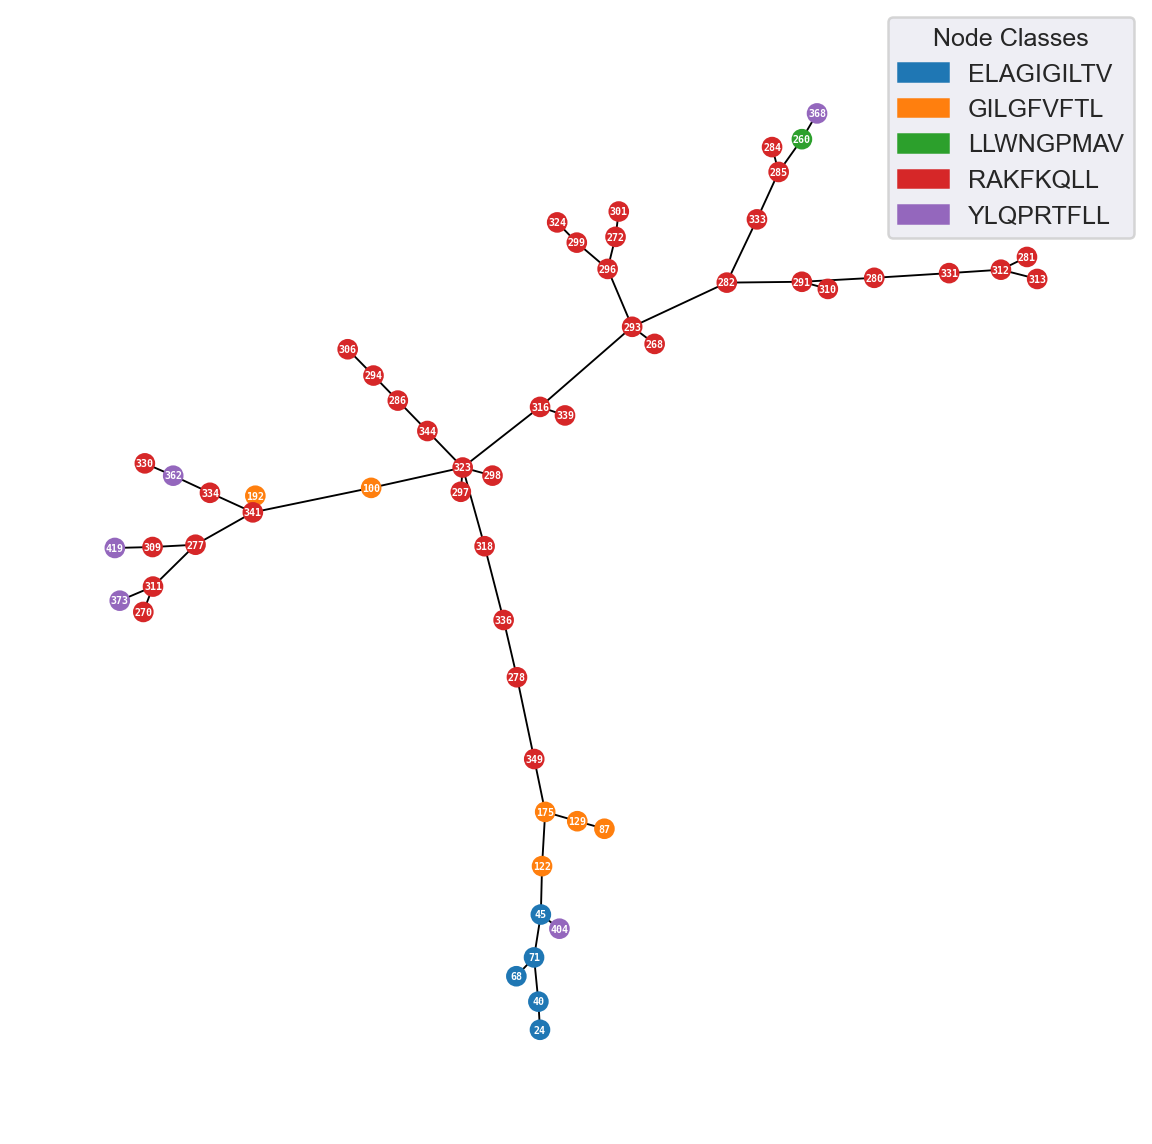

In [587]:
subgraph1=tree_pruned.subgraph(ecut_clusters[2]['members'])

edge_betweenness = nx.edge_betweenness_centrality(subgraph1)
node_betweenness = nx.betweenness_centrality(subgraph1)
# Sort it just for the printing // return ; These are list of tuples [(edge or node, centrality)]
sorted_edges = sorted(edge_betweenness.items(), key=lambda item: item[1], reverse=True)
sorted_nodes = sorted(node_betweenness.items(), key=lambda item: item[1], reverse=True)
print('\tEdge\tCentrality')
pprint(sorted_edges[:10])
print('\tNode\tCentrality')
pprint(sorted_nodes[:10])
# pprint(sorted_nodes[:7])
plot_mst_spring(subgraph1, color_map, scale=0.5)

Edge, centrality
[((416, 263), 0.6666666666666666), ((202, 263), 0.6666666666666666)]
Node, centrality
[(263, 1.0), (416, 0.0), (202, 0.0)]


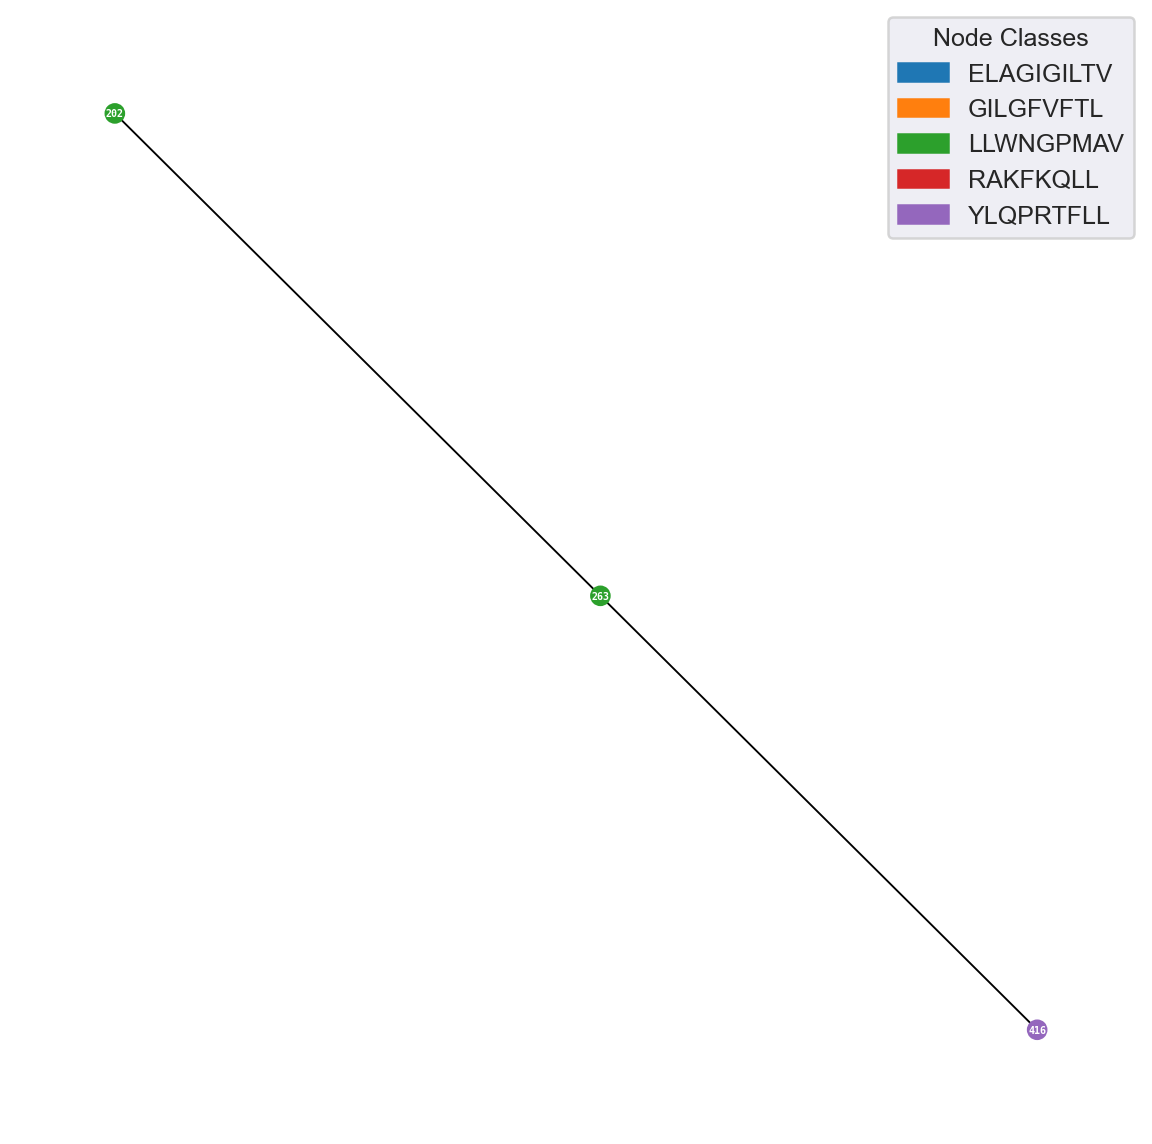

In [590]:
subgraph2 = tree_pruned.subgraph([202, 263, 416])

edge_betweenness2 = nx.edge_betweenness_centrality(subgraph2)
node_betweenness2 = nx.betweenness_centrality(subgraph2)
# Sort it just for the printing // return ; These are list of tuples [(edge or node, centrality)]
sorted_edges2 = sorted(edge_betweenness2.items(), key=lambda item: item[1], reverse=True)
sorted_nodes2 = sorted(node_betweenness2.items(), key=lambda item: item[1], reverse=True)
print('Edge, centrality')
pprint(sorted_edges2[:10])
print('Node, centrality')
pprint(sorted_nodes2[:10])
plot_mst_spring(subgraph2, color_map, scale=0.5)

In [593]:
[x for x in subgraph2.edges(data=True)]

[(416, 263, {'weight': 0.1453271508216858}),
 (202, 263, {'weight': 0.10888653993606567})]

In [537]:
weights= np.array([x[2]['weight'] for x in subgraph1.edges(data=True)])

In [542]:
np.where(weights>0.125)

(array([ 5,  7,  8, 10, 15, 16, 17, 18, 25, 28, 31, 32, 33, 44, 48, 49, 54,
        56, 61, 65, 70, 72, 76, 80]),)